In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df) 

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  specific_humidity          slp  vapor_pressure  \
0      2006-01-31     6501           5.386935  1018.534543        8.674922   
1      2006-02-28     6501           4.299929  1021.230347        6.942276   
2      2006-03-31     6501           6.505135  1018.968548       10.468176   
3      2006-04-30     6501          10.211263  1014.686944       16.358802   
4      2006-05-31     6501          11.737971  1014.236828       18.798749   
...           ...      ...                ...          ...             ...   
24057  2024-07-31     9858          15.211417  1013.969355       23.769169   
24058  2024-08-31     9858          15.149811  1015.112097       23.699154   
24059  2024-09-30     9858          10.720199  1014.393750       16.790240   
24060  2024-10-31     9858           6.989922  1018.230376       10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 2149)
(11, 2149)


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

[I 2025-05-15 20:37:36,964] A new study created in memory with name: no-name-7dfd7a36-b13d-4ac5-a66f-1ee4f124205d
[I 2025-05-15 20:46:33,588] Trial 0 finished with value: 0.09281377494335175 and parameters: {'lr': 0.002500682445885822, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.23985777906392158}. Best is trial 0 with value: 0.09281377494335175.


Cross Validation Accuracies:
[0.08559378981590271, 0.11370792984962463, 0.09331803023815155, 0.09168880432844162, 0.07976032048463821]
Mean Cross Validation Accuracy:
0.09281377494335175
Standard Deviation of Cross Validation Accuracy:
0.011494402116511896


[I 2025-05-15 20:55:15,691] Trial 1 finished with value: 0.19296314418315888 and parameters: {'lr': 0.03481781542881437, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.31089129114907316}. Best is trial 0 with value: 0.09281377494335175.


Cross Validation Accuracies:
[0.2605093717575073, 0.28585612773895264, 0.14566679298877716, 0.1346825659275055, 0.13810086250305176]
Mean Cross Validation Accuracy:
0.19296314418315888
Standard Deviation of Cross Validation Accuracy:
0.0660833410818274


[I 2025-05-15 21:07:24,042] Trial 2 finished with value: 0.03298273347318172 and parameters: {'lr': 0.00884011803961241, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.17003238341702198}. Best is trial 2 with value: 0.03298273347318172.


Cross Validation Accuracies:
[0.02647450752556324, 0.036377906799316406, 0.03178364410996437, 0.03471382334828377, 0.03556378558278084]
Mean Cross Validation Accuracy:
0.03298273347318172
Standard Deviation of Cross Validation Accuracy:
0.003605011077621782


[I 2025-05-15 21:17:17,602] Trial 3 finished with value: 0.7638457894325257 and parameters: {'lr': 0.012866268605047063, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.11046810716541891}. Best is trial 2 with value: 0.03298273347318172.


Cross Validation Accuracies:
[0.587782621383667, 0.556397557258606, 0.5465211272239685, 1.1327097415924072, 0.9958178997039795]
Mean Cross Validation Accuracy:
0.7638457894325257
Standard Deviation of Cross Validation Accuracy:
0.24945327904292924


[I 2025-05-15 21:26:45,796] Trial 4 finished with value: 0.036895531415939334 and parameters: {'lr': 0.008405125967414585, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.32590513088757855}. Best is trial 2 with value: 0.03298273347318172.


Cross Validation Accuracies:
[0.03951353579759598, 0.04586610943078995, 0.03337742015719414, 0.04396911710500717, 0.02175147458910942]
Mean Cross Validation Accuracy:
0.036895531415939334
Standard Deviation of Cross Validation Accuracy:
0.008707242908827607


[I 2025-05-15 21:36:50,961] Trial 5 finished with value: 0.06337361223995686 and parameters: {'lr': 0.009887664409011355, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.40250298097547854}. Best is trial 2 with value: 0.03298273347318172.


Cross Validation Accuracies:
[0.02838262729346752, 0.09603216499090195, 0.09542741626501083, 0.04703263193368912, 0.04999322071671486]
Mean Cross Validation Accuracy:
0.06337361223995686
Standard Deviation of Cross Validation Accuracy:
0.02743887374683352


[I 2025-05-15 21:46:16,115] Trial 6 finished with value: 0.028376109525561334 and parameters: {'lr': 0.02098072205766184, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2870707164913347}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.019804343581199646, 0.02349811978638172, 0.02858767658472061, 0.03337286040186882, 0.036617547273635864]
Mean Cross Validation Accuracy:
0.028376109525561334
Standard Deviation of Cross Validation Accuracy:
0.0061677148344625845


[I 2025-05-15 21:54:35,127] Trial 7 finished with value: 0.14992040097713472 and parameters: {'lr': 0.011057282778005615, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1892299534829056}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.20473985373973846, 0.1347535252571106, 0.12185180932283401, 0.18987874686717987, 0.09837806969881058]
Mean Cross Validation Accuracy:
0.14992040097713472
Standard Deviation of Cross Validation Accuracy:
0.04068496940548654


[I 2025-05-15 22:04:58,623] Trial 8 finished with value: 0.06885427311062813 and parameters: {'lr': 0.0077304344299026625, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4004148194436966}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.0937017947435379, 0.048306938260793686, 0.06717847287654877, 0.05718056112527847, 0.07790359854698181]
Mean Cross Validation Accuracy:
0.06885427311062813
Standard Deviation of Cross Validation Accuracy:
0.01587807576202869


[I 2025-05-15 22:13:39,824] Trial 9 finished with value: 0.0530182421207428 and parameters: {'lr': 0.007370126037573536, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3472669890725514}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.040595222264528275, 0.0916743203997612, 0.03398732468485832, 0.0353873074054718, 0.06344703584909439]
Mean Cross Validation Accuracy:
0.0530182421207428
Standard Deviation of Cross Validation Accuracy:
0.022047263894985264


[I 2025-05-15 22:22:03,929] Trial 10 finished with value: 0.09913501292467117 and parameters: {'lr': 0.19197906375826002, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.49284628001554087}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.09536370635032654, 0.09327293187379837, 0.10546589642763138, 0.09838683158159256, 0.10318569839000702]
Mean Cross Validation Accuracy:
0.09913501292467117
Standard Deviation of Cross Validation Accuracy:
0.0045964042797379066


[I 2025-05-15 22:31:58,359] Trial 11 finished with value: 0.03876571133732796 and parameters: {'lr': 0.07588098639168876, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20010931061935583}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.04133262112736702, 0.027935754507780075, 0.041153810918331146, 0.045799896121025085, 0.03760647401213646]
Mean Cross Validation Accuracy:
0.03876571133732796
Standard Deviation of Cross Validation Accuracy:
0.006006722852873606


[I 2025-05-15 22:44:37,583] Trial 12 finished with value: 0.02843734323978424 and parameters: {'lr': 0.001445056392241042, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1048608847745264}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.03301530331373215, 0.02665543742477894, 0.028645820915699005, 0.034614793956279755, 0.01925536058843136]
Mean Cross Validation Accuracy:
0.02843734323978424
Standard Deviation of Cross Validation Accuracy:
0.005415645344334171


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
[I 2025-05-15 22:53:21,561] Trial 13 finished with value: inf and parameters: {'lr': 0.932188981874, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.24118306194150438}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[inf, inf, inf, 0.480185329914093, inf]
Mean Cross Validation Accuracy:
inf
Standard Deviation of Cross Validation Accuracy:
nan


[I 2025-05-15 23:02:59,577] Trial 14 finished with value: 0.029327045381069183 and parameters: {'lr': 0.0011160355143567, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.10985527261782355}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.027202768251299858, 0.027635812759399414, 0.03526799753308296, 0.03744063526391983, 0.019088013097643852]
Mean Cross Validation Accuracy:
0.029327045381069183
Standard Deviation of Cross Validation Accuracy:
0.006532011274719306


[I 2025-05-15 23:13:48,860] Trial 15 finished with value: 0.05115582197904587 and parameters: {'lr': 0.0023473092406449056, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2554661397028777}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.041967637836933136, 0.03503913804888725, 0.047686971724033356, 0.034308869391679764, 0.09677649289369583]
Mean Cross Validation Accuracy:
0.05115582197904587
Standard Deviation of Cross Validation Accuracy:
0.023329245924416226


[I 2025-05-15 23:21:24,342] Trial 16 finished with value: 0.10552093833684921 and parameters: {'lr': 0.20894228808760898, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4953893785080935}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.09358438849449158, 0.10075777024030685, 0.11553008109331131, 0.11564760655164719, 0.10208484530448914]
Mean Cross Validation Accuracy:
0.10552093833684921
Standard Deviation of Cross Validation Accuracy:
0.008714448641582299


[I 2025-05-15 23:29:36,593] Trial 17 finished with value: 0.032683612778782845 and parameters: {'lr': 0.032813902311992514, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14767592198701146}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.03975440934300423, 0.023471450433135033, 0.030634963884949684, 0.04121271148324013, 0.02834452874958515]
Mean Cross Validation Accuracy:
0.032683612778782845
Standard Deviation of Cross Validation Accuracy:
0.006791615954221698


[I 2025-05-15 23:37:14,825] Trial 18 finished with value: 0.04235300198197365 and parameters: {'lr': 0.0030989446258466017, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3784391640258098}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.018770433962345123, 0.025761019438505173, 0.03253645449876785, 0.033586591482162476, 0.10111051052808762]
Mean Cross Validation Accuracy:
0.04235300198197365
Standard Deviation of Cross Validation Accuracy:
0.02985662662529395


[I 2025-05-15 23:46:23,043] Trial 19 finished with value: 3.9738776683807373 and parameters: {'lr': 0.08565613032510135, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4511759276628842}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[4.030898094177246, 4.097053050994873, 4.357511043548584, 3.928741455078125, 3.4551846981048584]
Mean Cross Validation Accuracy:
3.9738776683807373
Standard Deviation of Cross Validation Accuracy:
0.29552588568439836


[I 2025-05-15 23:54:41,899] Trial 20 finished with value: 0.03178735226392746 and parameters: {'lr': 0.001418586492980348, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.27601046119134626}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.021199122071266174, 0.02348998188972473, 0.032871827483177185, 0.03411141782999039, 0.04726441204547882]
Mean Cross Validation Accuracy:
0.03178735226392746
Standard Deviation of Cross Validation Accuracy:
0.009242009743315812


[I 2025-05-16 00:04:10,214] Trial 21 finished with value: 0.030771199241280557 and parameters: {'lr': 0.0012294835326319448, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1001293456477808}. Best is trial 6 with value: 0.028376109525561334.


Cross Validation Accuracies:
[0.03137127310037613, 0.027459485456347466, 0.0313023217022419, 0.034868236631155014, 0.028854679316282272]
Mean Cross Validation Accuracy:
0.030771199241280557
Standard Deviation of Cross Validation Accuracy:
0.0025325241122314346


[I 2025-05-16 00:13:57,116] Trial 22 finished with value: 0.026846948266029357 and parameters: {'lr': 0.0040717571203328275, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.13711812860140454}. Best is trial 22 with value: 0.026846948266029357.


Cross Validation Accuracies:
[0.019043466076254845, 0.026420675218105316, 0.03179849311709404, 0.03792827948927879, 0.019043827429413795]
Mean Cross Validation Accuracy:
0.026846948266029357
Standard Deviation of Cross Validation Accuracy:
0.007338643415234269


[I 2025-05-16 00:24:26,206] Trial 23 finished with value: 0.030676703527569772 and parameters: {'lr': 0.003695050922937317, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14489780741628194}. Best is trial 22 with value: 0.026846948266029357.


Cross Validation Accuracies:
[0.0182802677154541, 0.052775513380765915, 0.03016381897032261, 0.033161330968141556, 0.019002586603164673]
Mean Cross Validation Accuracy:
0.030676703527569772
Standard Deviation of Cross Validation Accuracy:
0.01252797228464215


[I 2025-05-16 00:33:45,725] Trial 24 finished with value: 0.02873865105211735 and parameters: {'lr': 0.004154026020153896, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20526152058137442}. Best is trial 22 with value: 0.026846948266029357.


Cross Validation Accuracies:
[0.017986800521612167, 0.03426513075828552, 0.0308037381619215, 0.04164725914597511, 0.018990326672792435]
Mean Cross Validation Accuracy:
0.02873865105211735
Standard Deviation of Cross Validation Accuracy:
0.009078224977047475


[I 2025-05-16 00:45:25,235] Trial 25 finished with value: 0.026680153980851173 and parameters: {'lr': 0.02724955468555282, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2163921507850458}. Best is trial 25 with value: 0.026680153980851173.


Cross Validation Accuracies:
[0.017849041149020195, 0.027426518499851227, 0.03243725001811981, 0.035639990121126175, 0.020047970116138458]
Mean Cross Validation Accuracy:
0.026680153980851173
Standard Deviation of Cross Validation Accuracy:
0.006869560322204324


[I 2025-05-16 00:56:39,109] Trial 26 finished with value: 0.030267347767949104 and parameters: {'lr': 0.020462912567271476, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.284933738464484}. Best is trial 25 with value: 0.026680153980851173.


Cross Validation Accuracies:
[0.019042164087295532, 0.028780071064829826, 0.032436251640319824, 0.03831524774432182, 0.032763004302978516]
Mean Cross Validation Accuracy:
0.030267347767949104
Standard Deviation of Cross Validation Accuracy:
0.006386202004856601


[I 2025-05-16 01:09:57,775] Trial 27 finished with value: 0.03194299638271332 and parameters: {'lr': 0.05671736116739095, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.15591550481391508}. Best is trial 25 with value: 0.026680153980851173.


Cross Validation Accuracies:
[0.02946600504219532, 0.02640080265700817, 0.04083380103111267, 0.03946106135845184, 0.023553311824798584]
Mean Cross Validation Accuracy:
0.03194299638271332
Standard Deviation of Cross Validation Accuracy:
0.006968585403810237


[I 2025-05-16 01:17:57,701] Trial 28 finished with value: 1.2920790433883667 and parameters: {'lr': 0.017924886356793002, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.21979055604495568}. Best is trial 25 with value: 0.026680153980851173.


Cross Validation Accuracies:
[0.6326454281806946, 1.6772793531417847, 1.6889821290969849, 0.7738661170005798, 1.6876221895217896]
Mean Cross Validation Accuracy:
1.2920790433883667
Standard Deviation of Cross Validation Accuracy:
0.4828587885652559


[I 2025-05-16 01:26:50,347] Trial 29 finished with value: 3.0035208225250245 and parameters: {'lr': 0.15300116282918114, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2619334729667643}. Best is trial 25 with value: 0.026680153980851173.


Cross Validation Accuracies:
[2.882035255432129, 2.936840772628784, 2.7120437622070312, 3.2420263290405273, 3.2446579933166504]
Mean Cross Validation Accuracy:
3.0035208225250245
Standard Deviation of Cross Validation Accuracy:
0.20937806023233327


[I 2025-05-16 01:36:05,113] Trial 30 finished with value: 0.5492734491825104 and parameters: {'lr': 0.02026605474875662, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.22642697184816327}. Best is trial 25 with value: 0.026680153980851173.


Cross Validation Accuracies:
[0.5828752517700195, 0.4784976840019226, 0.562550961971283, 0.6504052877426147, 0.47203806042671204]
Mean Cross Validation Accuracy:
0.5492734491825104
Standard Deviation of Cross Validation Accuracy:
0.06709327308559326


[I 2025-05-16 01:46:16,931] Trial 31 finished with value: 0.035205649212002754 and parameters: {'lr': 0.0020057620850056643, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.12555967160190618}. Best is trial 25 with value: 0.026680153980851173.


Cross Validation Accuracies:
[0.02723698504269123, 0.03305299952626228, 0.0335085466504097, 0.0348222553730011, 0.04740745946764946]
Mean Cross Validation Accuracy:
0.035205649212002754
Standard Deviation of Cross Validation Accuracy:
0.006633925395539856


[I 2025-05-16 01:57:11,718] Trial 32 finished with value: 0.04473181441426277 and parameters: {'lr': 0.003994901313927591, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.17765200121486147}. Best is trial 25 with value: 0.026680153980851173.


Cross Validation Accuracies:
[0.0337025448679924, 0.046435948461294174, 0.031199533492326736, 0.03683074936270714, 0.07549029588699341]
Mean Cross Validation Accuracy:
0.04473181441426277
Standard Deviation of Cross Validation Accuracy:
0.016224564696668817


[I 2025-05-16 02:06:57,376] Trial 33 finished with value: 0.02784814015030861 and parameters: {'lr': 0.006177795783055812, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3061103370785657}. Best is trial 25 with value: 0.026680153980851173.


Cross Validation Accuracies:
[0.022744856774806976, 0.02499290183186531, 0.029043622314929962, 0.035464681684970856, 0.02699463814496994]
Mean Cross Validation Accuracy:
0.02784814015030861
Standard Deviation of Cross Validation Accuracy:
0.004344312035157195


[I 2025-05-16 02:19:50,071] Trial 34 finished with value: 0.05666385293006897 and parameters: {'lr': 0.005299787392867047, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3085310769920482}. Best is trial 25 with value: 0.026680153980851173.


Cross Validation Accuracies:
[0.05131344869732857, 0.03394775837659836, 0.07843241840600967, 0.03956584259867668, 0.08005979657173157]
Mean Cross Validation Accuracy:
0.05666385293006897
Standard Deviation of Cross Validation Accuracy:
0.019278124163271234


[I 2025-05-16 02:29:00,126] Trial 35 finished with value: 0.025753608718514443 and parameters: {'lr': 0.0421969621584484, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3355242314527567}. Best is trial 35 with value: 0.025753608718514443.


Cross Validation Accuracies:
[0.01799347624182701, 0.026883618906140327, 0.029192538931965828, 0.033886514604091644, 0.0208118949085474]
Mean Cross Validation Accuracy:
0.025753608718514443
Standard Deviation of Cross Validation Accuracy:
0.005725163990946309


[I 2025-05-16 02:38:10,719] Trial 36 finished with value: 0.3275431364774704 and parameters: {'lr': 0.04300694563611445, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3403618963979765}. Best is trial 35 with value: 0.025753608718514443.


Cross Validation Accuracies:
[0.15564680099487305, 0.1526467204093933, 0.12091965973377228, 0.8687500357627869, 0.3397524654865265]
Mean Cross Validation Accuracy:
0.3275431364774704
Standard Deviation of Cross Validation Accuracy:
0.281383845732599


[I 2025-05-16 02:48:07,866] Trial 37 finished with value: 0.05916372984647751 and parameters: {'lr': 0.39753708642749536, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.36530117070219015}. Best is trial 35 with value: 0.025753608718514443.


Cross Validation Accuracies:
[0.01856798678636551, 0.04792070388793945, 0.05502978712320328, 0.13645926117897034, 0.037840910255908966]
Mean Cross Validation Accuracy:
0.05916372984647751
Standard Deviation of Cross Validation Accuracy:
0.04054817201554373


[I 2025-05-16 02:58:20,156] Trial 38 finished with value: 0.029364822804927825 and parameters: {'lr': 0.01408129203484286, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3191965176642935}. Best is trial 35 with value: 0.025753608718514443.


Cross Validation Accuracies:
[0.019430026412010193, 0.027942053973674774, 0.03048739582300186, 0.033173758536577225, 0.035790879279375076]
Mean Cross Validation Accuracy:
0.029364822804927825
Standard Deviation of Cross Validation Accuracy:
0.005617594038686726


[I 2025-05-16 03:07:13,557] Trial 39 finished with value: 0.07399788126349449 and parameters: {'lr': 0.005636071431162636, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.42968750724732807}. Best is trial 35 with value: 0.025753608718514443.


Cross Validation Accuracies:
[0.10922367125749588, 0.054383181035518646, 0.10320531576871872, 0.05628380551934242, 0.04689343273639679]
Mean Cross Validation Accuracy:
0.07399788126349449
Standard Deviation of Cross Validation Accuracy:
0.02655976876984983


[I 2025-05-16 03:16:07,151] Trial 40 finished with value: 0.025364741683006287 and parameters: {'lr': 0.04592627660625399, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2918550381236108}. Best is trial 40 with value: 0.025364741683006287.


Cross Validation Accuracies:
[0.01821294240653515, 0.025665881112217903, 0.029567457735538483, 0.03407638892531395, 0.01930103823542595]
Mean Cross Validation Accuracy:
0.025364741683006287
Standard Deviation of Cross Validation Accuracy:
0.006025994311971679


[I 2025-05-16 03:24:45,836] Trial 41 finished with value: 0.024955185130238533 and parameters: {'lr': 0.028305881023218803, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.33579987354184826}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.018013671040534973, 0.024707498028874397, 0.029471687972545624, 0.033468302339315414, 0.019114766269922256]
Mean Cross Validation Accuracy:
0.024955185130238533
Standard Deviation of Cross Validation Accuracy:
0.0059199395564772835


[I 2025-05-16 03:35:17,549] Trial 42 finished with value: 0.13912276178598404 and parameters: {'lr': 0.030870457301965238, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3371800365795761}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.0211756844073534, 0.02415989153087139, 0.5959251523017883, 0.03323740139603615, 0.021115679293870926]
Mean Cross Validation Accuracy:
0.13912276178598404
Standard Deviation of Cross Validation Accuracy:
0.22844420747465558


[I 2025-05-16 03:45:25,949] Trial 43 finished with value: 0.030035713315010072 and parameters: {'lr': 0.11879295073901552, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3807765765381365}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.01873769611120224, 0.033314768224954605, 0.03542206063866615, 0.03407987207174301, 0.028624169528484344]
Mean Cross Validation Accuracy:
0.030035713315010072
Standard Deviation of Cross Validation Accuracy:
0.0060952080726086


[I 2025-05-16 03:54:09,746] Trial 44 finished with value: 0.025480692461133003 and parameters: {'lr': 0.05039590111613634, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.36379659203056225}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.017854517325758934, 0.0268528051674366, 0.028764838352799416, 0.03316348418593407, 0.020767817273736]
Mean Cross Validation Accuracy:
0.025480692461133003
Standard Deviation of Cross Validation Accuracy:
0.0055147680990337376


[I 2025-05-16 04:03:06,354] Trial 45 finished with value: 0.02669023983180523 and parameters: {'lr': 0.047380613888131494, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35806432238335834}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.019946608692407608, 0.023233192041516304, 0.03145270794630051, 0.03892780467867851, 0.019890885800123215]
Mean Cross Validation Accuracy:
0.02669023983180523
Standard Deviation of Cross Validation Accuracy:
0.007430989860573868


[I 2025-05-16 04:10:47,216] Trial 46 finished with value: 0.5094433903694153 and parameters: {'lr': 0.027357685204901568, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.40044351530505595}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.2122865617275238, 0.4654185473918915, 0.8678125143051147, 0.3093879818916321, 0.6923113465309143]
Mean Cross Validation Accuracy:
0.5094433903694153
Standard Deviation of Cross Validation Accuracy:
0.24171539150415697


[I 2025-05-16 04:20:26,706] Trial 47 finished with value: 1.0533593647181987 and parameters: {'lr': 0.06677092925332698, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.29419927250219563}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.024921773001551628, 0.026197416707873344, 5.163135528564453, 0.03335881233215332, 0.019183292984962463]
Mean Cross Validation Accuracy:
1.0533593647181987
Standard Deviation of Cross Validation Accuracy:
2.054893035592294


[I 2025-05-16 04:29:36,164] Trial 48 finished with value: 0.025036099553108215 and parameters: {'lr': 0.096334182695642, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.32745348950068753}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.017873013392090797, 0.02323395200073719, 0.02890666574239731, 0.03344154357910156, 0.021725323051214218]
Mean Cross Validation Accuracy:
0.025036099553108215
Standard Deviation of Cross Validation Accuracy:
0.005498209746743838


[I 2025-05-16 04:36:00,810] Trial 49 finished with value: 0.3251664131879807 and parameters: {'lr': 0.09868573315720017, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3267777113989654}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.258313924074173, 0.3230902850627899, 0.3862786591053009, 0.175684854388237, 0.48246434330940247]
Mean Cross Validation Accuracy:
0.3251664131879807
Standard Deviation of Cross Validation Accuracy:
0.10516239579949471


[I 2025-05-16 04:45:12,927] Trial 50 finished with value: 0.028738482668995858 and parameters: {'lr': 0.24398804011763459, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4199292244888577}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.029242010787129402, 0.026100635528564453, 0.029323620721697807, 0.033865638077259064, 0.02516050823032856]
Mean Cross Validation Accuracy:
0.028738482668995858
Standard Deviation of Cross Validation Accuracy:
0.003054301501390859


[I 2025-05-16 04:55:47,631] Trial 51 finished with value: 0.025497163459658623 and parameters: {'lr': 0.04574819938382003, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35380727647679205}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.017856786027550697, 0.023232020437717438, 0.03351949155330658, 0.033244114369153976, 0.019633404910564423]
Mean Cross Validation Accuracy:
0.025497163459658623
Standard Deviation of Cross Validation Accuracy:
0.006667276820010587


[I 2025-05-16 05:05:54,045] Trial 52 finished with value: 0.025938986986875533 and parameters: {'lr': 0.04473658852651598, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3586294358503861}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.021014604717493057, 0.02583460882306099, 0.0293098334223032, 0.03338509425520897, 0.020150793716311455]
Mean Cross Validation Accuracy:
0.025938986986875533
Standard Deviation of Cross Validation Accuracy:
0.004991407336939283


[I 2025-05-16 05:15:56,002] Trial 53 finished with value: 0.026383399590849878 and parameters: {'lr': 0.06522403407247336, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3301660784538235}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.026739470660686493, 0.023381082341074944, 0.02860858291387558, 0.03362306207418442, 0.019564799964427948]
Mean Cross Validation Accuracy:
0.026383399590849878
Standard Deviation of Cross Validation Accuracy:
0.00475390681511923


[I 2025-05-16 05:25:46,518] Trial 54 finished with value: 0.028702123463153838 and parameters: {'lr': 0.1211168644220483, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3869752509578614}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.018406128510832787, 0.02342366613447666, 0.03839625418186188, 0.03393958508968353, 0.029344983398914337]
Mean Cross Validation Accuracy:
0.028702123463153838
Standard Deviation of Cross Validation Accuracy:
0.007151084776544916


[I 2025-05-16 05:35:08,559] Trial 55 finished with value: 0.025992125272750854 and parameters: {'lr': 0.043358849711092586, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35540914498457715}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.018948916345834732, 0.023843465372920036, 0.030131829902529716, 0.03326387703418732, 0.02377253770828247]
Mean Cross Validation Accuracy:
0.025992125272750854
Standard Deviation of Cross Validation Accuracy:
0.005082629799846561


[I 2025-05-16 05:43:51,737] Trial 56 finished with value: 0.027441935241222383 and parameters: {'lr': 0.0884164145118844, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.274450977556231}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.022012434899806976, 0.02367379516363144, 0.03592952713370323, 0.03589679300785065, 0.019697126001119614]
Mean Cross Validation Accuracy:
0.027441935241222383
Standard Deviation of Cross Validation Accuracy:
0.007031134471116012


[I 2025-05-16 05:52:22,936] Trial 57 finished with value: 0.026125430315732955 and parameters: {'lr': 0.052675005821171905, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3165587534375992}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.024794600903987885, 0.02459971234202385, 0.028752543032169342, 0.03347665071487427, 0.019003644585609436]
Mean Cross Validation Accuracy:
0.026125430315732955
Standard Deviation of Cross Validation Accuracy:
0.004811671577027444


[I 2025-05-16 06:02:22,262] Trial 58 finished with value: 0.2603197142481804 and parameters: {'lr': 0.015036464741017674, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.369510323031868}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.12496180832386017, 0.25806358456611633, 0.6579995155334473, 0.09510981291532516, 0.16546384990215302]
Mean Cross Validation Accuracy:
0.2603197142481804
Standard Deviation of Cross Validation Accuracy:
0.2062852508866751


[I 2025-05-16 06:10:06,324] Trial 59 finished with value: 0.025293315201997756 and parameters: {'lr': 0.03583709516601712, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.34603916675550556}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.020162316039204597, 0.02431655488908291, 0.028681468218564987, 0.03353565186262131, 0.019770585000514984]
Mean Cross Validation Accuracy:
0.025293315201997756
Standard Deviation of Cross Validation Accuracy:
0.005238271785361508


[I 2025-05-16 06:17:25,682] Trial 60 finished with value: 0.02829238325357437 and parameters: {'lr': 0.010567530598204903, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.34746578016974555}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.017905525863170624, 0.02656043879687786, 0.039700210094451904, 0.03811078891158104, 0.019184952601790428]
Mean Cross Validation Accuracy:
0.02829238325357437
Standard Deviation of Cross Validation Accuracy:
0.009169202081133818


[I 2025-05-16 06:25:19,957] Trial 61 finished with value: 0.025351133570075034 and parameters: {'lr': 0.03535668922467501, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2989213757533133}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.01834809221327305, 0.025885792449116707, 0.02907387726008892, 0.03341115266084671, 0.02003675326704979]
Mean Cross Validation Accuracy:
0.025351133570075034
Standard Deviation of Cross Validation Accuracy:
0.005592741987475228


[I 2025-05-16 06:32:12,064] Trial 62 finished with value: 0.025143614783883095 and parameters: {'lr': 0.024005004311710744, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3008126896962006}. Best is trial 41 with value: 0.024955185130238533.


Cross Validation Accuracies:
[0.017952563241124153, 0.02461313083767891, 0.028851835057139397, 0.03392598778009415, 0.020374557003378868]
Mean Cross Validation Accuracy:
0.025143614783883095
Standard Deviation of Cross Validation Accuracy:
0.005755302262455903


[I 2025-05-16 06:39:05,390] Trial 63 finished with value: 0.024830025807023048 and parameters: {'lr': 0.024858313349520995, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.29682482995863835}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.017869621515274048, 0.025036513805389404, 0.028588254004716873, 0.033651500940322876, 0.01900423876941204]
Mean Cross Validation Accuracy:
0.024830025807023048
Standard Deviation of Cross Validation Accuracy:
0.005905461243950923


[I 2025-05-16 06:45:47,083] Trial 64 finished with value: 0.0250215582549572 and parameters: {'lr': 0.027408766895816374, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.29664057072771943}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.01819702424108982, 0.023540126159787178, 0.029108820483088493, 0.03360462933778763, 0.020657191053032875]
Mean Cross Validation Accuracy:
0.0250215582549572
Standard Deviation of Cross Validation Accuracy:
0.005624792056008722


[I 2025-05-16 06:54:17,557] Trial 65 finished with value: 0.025141388550400733 and parameters: {'lr': 0.023078385818577733, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.27036847339757814}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.018107926473021507, 0.02331792190670967, 0.03181108832359314, 0.03342704474925995, 0.019042961299419403]
Mean Cross Validation Accuracy:
0.025141388550400733
Standard Deviation of Cross Validation Accuracy:
0.006373734039639783


[I 2025-05-16 07:02:54,244] Trial 66 finished with value: 0.02545310594141483 and parameters: {'lr': 0.024541553738685048, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2526841006075661}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.01826067641377449, 0.025282738730311394, 0.029606126248836517, 0.03342519700527191, 0.020690791308879852]
Mean Cross Validation Accuracy:
0.02545310594141483
Standard Deviation of Cross Validation Accuracy:
0.005572100533196353


[I 2025-05-16 07:10:43,376] Trial 67 finished with value: 0.02509957142174244 and parameters: {'lr': 0.017243177313151982, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2634932473466148}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.0194595605134964, 0.02403172105550766, 0.02858358807861805, 0.03430192917585373, 0.01912105828523636]
Mean Cross Validation Accuracy:
0.02509957142174244
Standard Deviation of Cross Validation Accuracy:
0.005753510355830026


[I 2025-05-16 07:18:49,319] Trial 68 finished with value: 0.10688415914773941 and parameters: {'lr': 0.017943122113141488, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.27353961650228714}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.0852043479681015, 0.2046021819114685, 0.12084854394197464, 0.07660646736621857, 0.04715925455093384]
Mean Cross Validation Accuracy:
0.10688415914773941
Standard Deviation of Cross Validation Accuracy:
0.05421740140772739


[I 2025-05-16 07:26:28,931] Trial 69 finished with value: 0.028365080803632738 and parameters: {'lr': 0.012064287444415803, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.23985666095210556}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.03161868453025818, 0.024259882047772408, 0.03312041237950325, 0.033826835453510284, 0.01899958960711956]
Mean Cross Validation Accuracy:
0.028365080803632738
Standard Deviation of Cross Validation Accuracy:
0.0057895589061503485


[I 2025-05-16 07:33:11,963] Trial 70 finished with value: 0.02494359165430069 and parameters: {'lr': 0.02508854163329457, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26358647305371813}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.01784733310341835, 0.0245530903339386, 0.028604118153452873, 0.03391335532069206, 0.019800061360001564]
Mean Cross Validation Accuracy:
0.02494359165430069
Standard Deviation of Cross Validation Accuracy:
0.005845021729171898


[I 2025-05-16 07:39:53,884] Trial 71 finished with value: 0.03302931115031242 and parameters: {'lr': 0.00898423526228183, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.258479966652497}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.01848853938281536, 0.033923983573913574, 0.05975474417209625, 0.03395093232393265, 0.019028356298804283]
Mean Cross Validation Accuracy:
0.03302931115031242
Standard Deviation of Cross Validation Accuracy:
0.014989058508682124


[I 2025-05-16 07:47:08,879] Trial 72 finished with value: 0.026031762734055518 and parameters: {'lr': 0.02215861381082666, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2824508355631287}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.020377883687615395, 0.026383686810731888, 0.028975607827305794, 0.03454487770795822, 0.019876757636666298]
Mean Cross Validation Accuracy:
0.026031762734055518
Standard Deviation of Cross Validation Accuracy:
0.005497520114894471


[I 2025-05-16 07:54:00,433] Trial 73 finished with value: 0.030465180799365044 and parameters: {'lr': 0.015439799503585188, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2402227561858107}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.018575545400381088, 0.047308050096035004, 0.028789032250642776, 0.03396382927894592, 0.023689446970820427]
Mean Cross Validation Accuracy:
0.030465180799365044
Standard Deviation of Cross Validation Accuracy:
0.00985906953136878


[I 2025-05-16 08:01:07,854] Trial 74 finished with value: 0.02508280910551548 and parameters: {'lr': 0.026981367884715324, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.31676224658128244}. Best is trial 63 with value: 0.024830025807023048.


Cross Validation Accuracies:
[0.01789441518485546, 0.025469405576586723, 0.02895413152873516, 0.03391923010349274, 0.019176863133907318]
Mean Cross Validation Accuracy:
0.02508280910551548
Standard Deviation of Cross Validation Accuracy:
0.005996201050124958


[I 2025-05-16 08:07:52,564] Trial 75 finished with value: 0.02482585608959198 and parameters: {'lr': 0.031100585463278898, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26665809118262074}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.01811363361775875, 0.024592144414782524, 0.02883552759885788, 0.03319515287876129, 0.019392821937799454]
Mean Cross Validation Accuracy:
0.02482585608959198
Standard Deviation of Cross Validation Accuracy:
0.005670079472287625


[I 2025-05-16 08:14:30,269] Trial 76 finished with value: 0.02504746466875076 and parameters: {'lr': 0.017970851589646036, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3192183438086399}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.01840340532362461, 0.025958510115742683, 0.02860766462981701, 0.03316967189311981, 0.0190980713814497]
Mean Cross Validation Accuracy:
0.02504746466875076
Standard Deviation of Cross Validation Accuracy:
0.0056393985997337465


[I 2025-05-16 08:21:48,374] Trial 77 finished with value: 0.32127805352211 and parameters: {'lr': 0.033137963501068235, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3166038235060387}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.22607897222042084, 0.3990785777568817, 0.38795584440231323, 0.3893885910511017, 0.20388828217983246]
Mean Cross Validation Accuracy:
0.32127805352211
Standard Deviation of Cross Validation Accuracy:
0.08715631725450018


[I 2025-05-16 08:28:50,205] Trial 78 finished with value: 0.025302258878946306 and parameters: {'lr': 0.02857344201165957, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2842922532915226}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.018964923918247223, 0.023612074553966522, 0.02876497432589531, 0.033182669430971146, 0.02198665216565132]
Mean Cross Validation Accuracy:
0.025302258878946306
Standard Deviation of Cross Validation Accuracy:
0.005061680631346799


[I 2025-05-16 08:35:31,494] Trial 79 finished with value: 0.02756403535604477 and parameters: {'lr': 0.012775014386763494, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.31933775319351504}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.021882349625229836, 0.027516253292560577, 0.03274117782711983, 0.03480369970202446, 0.020876696333289146]
Mean Cross Validation Accuracy:
0.02756403535604477
Standard Deviation of Cross Validation Accuracy:
0.005589631169994415


[I 2025-05-16 08:42:29,280] Trial 80 finished with value: 0.08481636047363281 and parameters: {'lr': 0.019141621578323824, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.30622376864763917}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.15245555341243744, 0.07615945488214493, 0.0642053633928299, 0.06612476706504822, 0.06513666361570358]
Mean Cross Validation Accuracy:
0.08481636047363281
Standard Deviation of Cross Validation Accuracy:
0.03409246769909585


[I 2025-05-16 08:49:27,266] Trial 81 finished with value: 0.02796040289103985 and parameters: {'lr': 0.017155766541539563, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26417678700523606}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.018142815679311752, 0.030363207682967186, 0.029520172625780106, 0.03356952965259552, 0.028206288814544678]
Mean Cross Validation Accuracy:
0.02796040289103985
Standard Deviation of Cross Validation Accuracy:
0.005217549886066938


[I 2025-05-16 08:56:32,587] Trial 82 finished with value: 0.02483108788728714 and parameters: {'lr': 0.037005053776757425, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.22862737648572132}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.018985344097018242, 0.023242145776748657, 0.02905178815126419, 0.0338815413415432, 0.018994620069861412]
Mean Cross Validation Accuracy:
0.02483108788728714
Standard Deviation of Cross Validation Accuracy:
0.0058392950348813075


[I 2025-05-16 09:03:26,770] Trial 83 finished with value: 0.02496551163494587 and parameters: {'lr': 0.03589691323741256, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.23330074972159642}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.017864620313048363, 0.023927010595798492, 0.029474275186657906, 0.03450770676136017, 0.019053945317864418]
Mean Cross Validation Accuracy:
0.02496551163494587
Standard Deviation of Cross Validation Accuracy:
0.006290154129920398


[I 2025-05-16 09:09:52,641] Trial 84 finished with value: 0.025101280212402342 and parameters: {'lr': 0.037159217205656916, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.22866860822830395}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.017842845991253853, 0.024299530312418938, 0.029147125780582428, 0.034802403301000595, 0.019414495676755905]
Mean Cross Validation Accuracy:
0.025101280212402342
Standard Deviation of Cross Validation Accuracy:
0.006263351245801674


[I 2025-05-16 09:16:36,342] Trial 85 finished with value: 0.02562132626771927 and parameters: {'lr': 0.057720398097940946, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.19732644078344452}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.018070029094815254, 0.02385583519935608, 0.02956237643957138, 0.03389022871851921, 0.02272816188633442]
Mean Cross Validation Accuracy:
0.02562132626771927
Standard Deviation of Cross Validation Accuracy:
0.0055211606033802926


[I 2025-05-16 09:23:53,162] Trial 86 finished with value: 0.06367455124855041 and parameters: {'lr': 0.3385016987986505, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.24658965070824318}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.05110274255275726, 0.15876835584640503, 0.050759926438331604, 0.038583189249038696, 0.019158542156219482]
Mean Cross Validation Accuracy:
0.06367455124855041
Standard Deviation of Cross Validation Accuracy:
0.04894674880575078


[I 2025-05-16 09:30:28,359] Trial 87 finished with value: 0.027021020650863647 and parameters: {'lr': 0.07402118196203053, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21528471232263569}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.01844489574432373, 0.02425409108400345, 0.03775748610496521, 0.03357517719268799, 0.02107345312833786]
Mean Cross Validation Accuracy:
0.027021020650863647
Standard Deviation of Cross Validation Accuracy:
0.007413609586394445


[I 2025-05-16 09:38:04,580] Trial 88 finished with value: 0.04878013618290424 and parameters: {'lr': 0.0070847363056136285, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.23472051228125415}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.029718754813075066, 0.06947014480829239, 0.0444769412279129, 0.041515931487083435, 0.058718908578157425]
Mean Cross Validation Accuracy:
0.04878013618290424
Standard Deviation of Cross Validation Accuracy:
0.013867069409596257


[I 2025-05-16 09:44:36,115] Trial 89 finished with value: 0.027755089104175568 and parameters: {'lr': 0.038623950020825346, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2887505523456539}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.018887024372816086, 0.03750096634030342, 0.02901725098490715, 0.0340195968747139, 0.019350606948137283]
Mean Cross Validation Accuracy:
0.027755089104175568
Standard Deviation of Cross Validation Accuracy:
0.007551120787177622


[I 2025-05-16 09:50:21,477] Trial 90 finished with value: 0.32585434913635253 and parameters: {'lr': 0.029967317992756898, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.20981438180084777}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.701023519039154, 0.18208438158035278, 0.3529169261455536, 0.190885528922081, 0.20236138999462128]
Mean Cross Validation Accuracy:
0.32585434913635253
Standard Deviation of Cross Validation Accuracy:
0.19779847627249458


[I 2025-05-16 09:56:23,032] Trial 91 finished with value: 0.025360419973731042 and parameters: {'lr': 0.0262728705662086, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.32920848253276597}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.018042869865894318, 0.02730534039437771, 0.028988419100642204, 0.033276353031396866, 0.01918911747634411]
Mean Cross Validation Accuracy:
0.025360419973731042
Standard Deviation of Cross Validation Accuracy:
0.005852155216258683


[I 2025-05-16 10:02:22,273] Trial 92 finished with value: 0.02667456790804863 and parameters: {'lr': 0.020061532114632952, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2470967624752594}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.018975213170051575, 0.029536807909607887, 0.030331553891301155, 0.03325115889310837, 0.021278105676174164]
Mean Cross Validation Accuracy:
0.02667456790804863
Standard Deviation of Cross Validation Accuracy:
0.005535691127484727


[I 2025-05-16 10:08:03,854] Trial 93 finished with value: 0.025781263038516043 and parameters: {'lr': 0.03031987353230153, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18482115825017803}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.01784127578139305, 0.023660926148295403, 0.03271862864494324, 0.033322472125291824, 0.021363012492656708]
Mean Cross Validation Accuracy:
0.025781263038516043
Standard Deviation of Cross Validation Accuracy:
0.006197693766313417


[I 2025-05-16 10:14:25,646] Trial 94 finished with value: 0.05073538236320019 and parameters: {'lr': 0.8352359073954958, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3073762671270757}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.026555286720395088, 0.04407450184226036, 0.06668105721473694, 0.06473790854215622, 0.05162815749645233]
Mean Cross Validation Accuracy:
0.05073538236320019
Standard Deviation of Cross Validation Accuracy:
0.014698140616494807


[I 2025-05-16 10:21:56,800] Trial 95 finished with value: 0.025401276350021363 and parameters: {'lr': 0.013849798047078527, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.29469690288806377}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.017972001805901527, 0.025410549715161324, 0.028638511896133423, 0.0332188755273819, 0.02176644280552864]
Mean Cross Validation Accuracy:
0.025401276350021363
Standard Deviation of Cross Validation Accuracy:
0.005291517211958345


[I 2025-05-16 10:28:34,063] Trial 96 finished with value: 0.03294443786144256 and parameters: {'lr': 0.022392906214638575, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.32059748193283255}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.027183646336197853, 0.028438089415431023, 0.0288255512714386, 0.06082172691822052, 0.019453175365924835]
Mean Cross Validation Accuracy:
0.03294443786144256
Standard Deviation of Cross Validation Accuracy:
0.014350028090102343


[I 2025-05-16 10:34:32,784] Trial 97 finished with value: 0.027942243590950967 and parameters: {'lr': 0.06408705260277568, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2794357516539548}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.031947847455739975, 0.02415044791996479, 0.02909717708826065, 0.03358122333884239, 0.02093452215194702]
Mean Cross Validation Accuracy:
0.027942243590950967
Standard Deviation of Cross Validation Accuracy:
0.004746845278269248


[I 2025-05-16 10:39:42,553] Trial 98 finished with value: 0.025222548097372056 and parameters: {'lr': 0.03782326307623479, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.22429742708126363}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.020465148612856865, 0.02354009635746479, 0.02862877957522869, 0.03337795287370682, 0.02010076306760311]
Mean Cross Validation Accuracy:
0.025222548097372056
Standard Deviation of Cross Validation Accuracy:
0.005095276548925542


[I 2025-05-16 10:45:07,249] Trial 99 finished with value: 0.02512633427977562 and parameters: {'lr': 0.02638803006063945, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.34080059994670614}. Best is trial 75 with value: 0.02482585608959198.


Cross Validation Accuracies:
[0.01849021576344967, 0.023943083360791206, 0.028661711141467094, 0.03423851355910301, 0.020298147574067116]
Mean Cross Validation Accuracy:
0.02512633427977562
Standard Deviation of Cross Validation Accuracy:
0.005732019527844769
Number of finished trials: 100
Best trial: {'lr': 0.031100585463278898, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26665809118262074}
Best hyperparameters:  {'lr': 0.031100585463278898, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26665809118262074}
Fold 1:
Epoch 1/100
84/84 [==============================] - 21s 138ms/step - loss: 0.6936 - val_loss: 0.0515
Epoch 2/100
84/84 [==============================] - 8s 97ms/step - loss: 0.0329 - val_loss: 0.0342
Epoch 3/100
84/84 [==============================] - 9s 102ms/step - loss: 0.0440 - val_loss: 0.0201
Epoch 4/100
84/84 [==============================] - 8s 98ms/step - loss: 0.0300 - val_lo

IndexError: index 10 is out of bounds for axis 0 with size 10

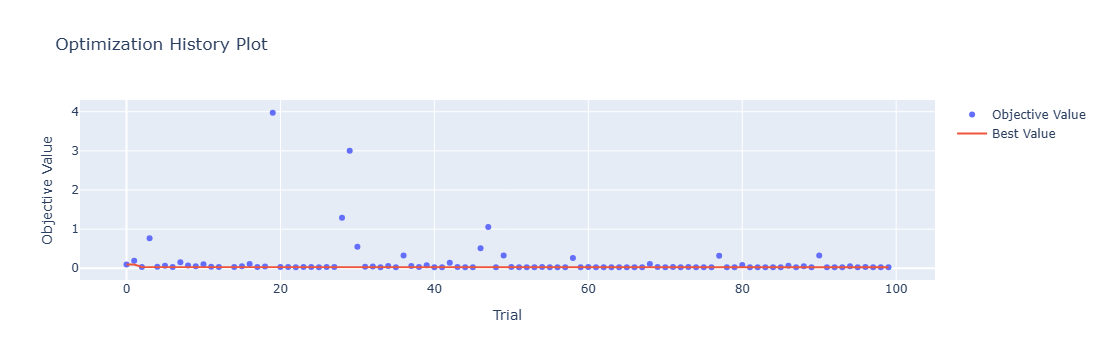

In [4]:
optuna.visualization.plot_optimization_history(study)

[W 2025-05-16 21:40:23,846] Trial 13 is omitted in visualization because its objective value is inf or nan.


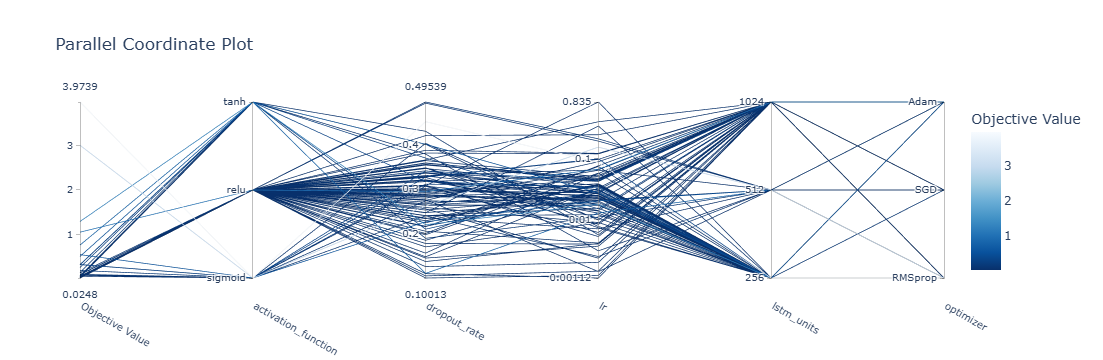

In [6]:
optuna.visualization.plot_parallel_coordinate(study)

[W 2025-05-16 21:40:28,987] Trial 13 is omitted in visualization because its objective value is inf or nan.


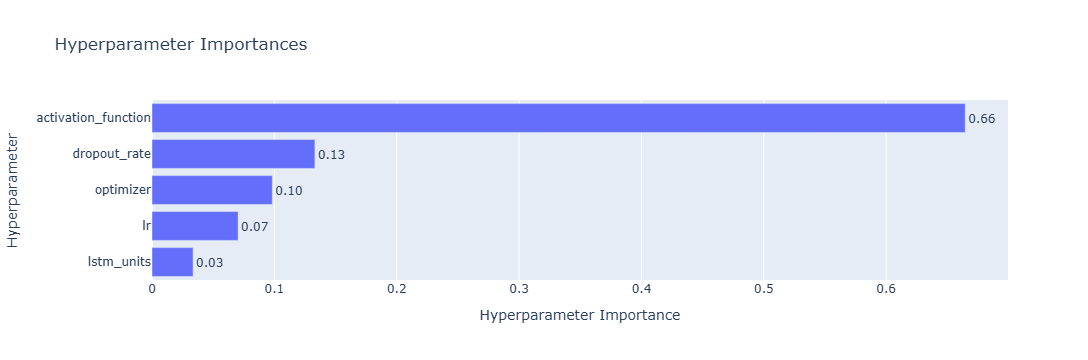

In [7]:
optuna.visualization.plot_param_importances(study)

[W 2025-05-16 21:40:36,201] Trial 13 is omitted in visualization because its objective value is inf or nan.


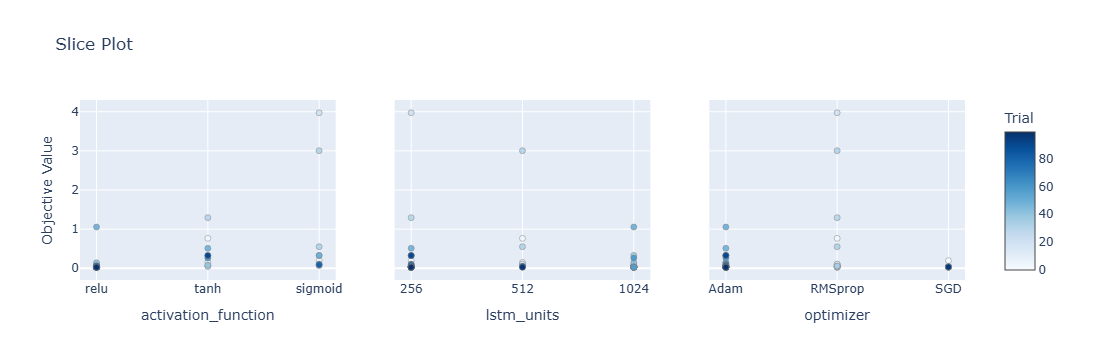

In [8]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

[W 2025-05-16 21:40:46,335] Trial 13 is omitted in visualization because its objective value is inf or nan.


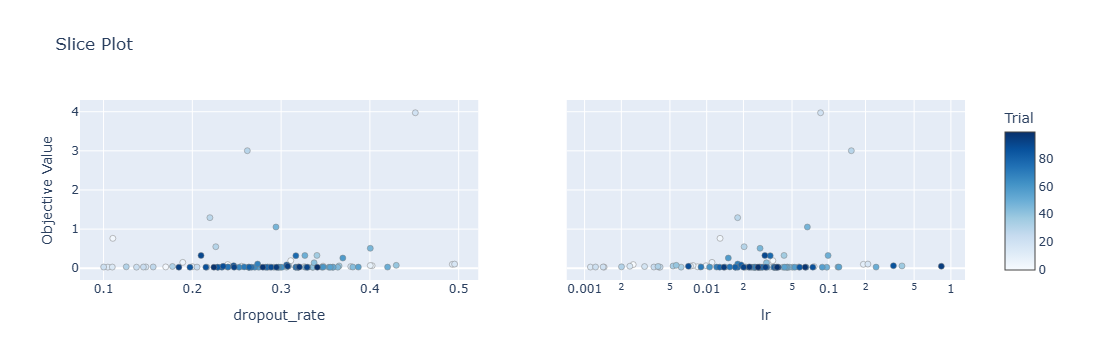

In [9]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 6s 25ms/step - loss: 0.6909 - accuracy: 0.0000e+00 - mae: 0.6909 - rmse: 0.6909 - mape: 140.9171 - pearson: nan - val_loss: 0.0211 - val_accuracy: 0.0000e+00 - val_mae: 0.0211 - val_rmse: 0.0211 - val_mape: 4.4553 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0467 - accuracy: 0.0000e+00 - mae: 0.0467 - rmse: 0.0467 - mape: 9.4146 - pearson: nan - val_loss: 0.0205 - val_accuracy: 0.0000e+00 - val_mae: 0.0205 - val_rmse: 0.0205 - val_mape: 4.1650 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0362 - accuracy: 0.0000e+00 - mae: 0.0362 - rmse: 0.0362 - mape: 7.2920 - pearson: nan - val_loss: 0.0201 - val_accuracy: 0.0000e+00 - val_mae: 0.0201 - val_rmse: 0.0201 - val_mape: 4.0962 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0283 - accuracy: 0.0000e+00 - mae: 0.0283 - rmse: 0.0283 - mape: 5.678

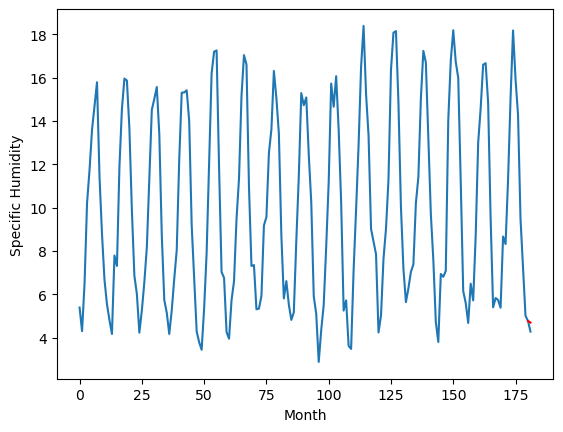

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.90		4.39		-0.51
[180, 181]
[7.05, 4.3869951993227]


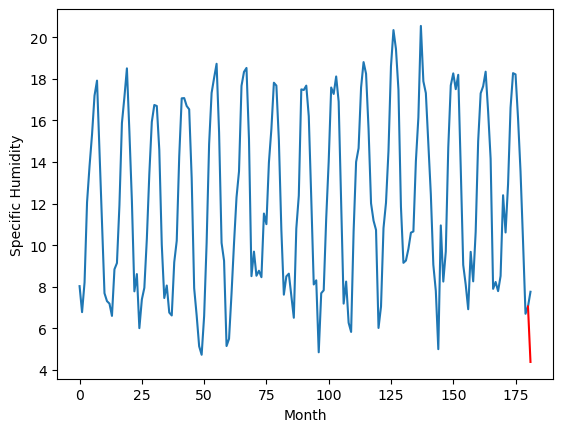

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.82		4.28		-0.54
[180, 181]
[5.06, 4.276995199322701]


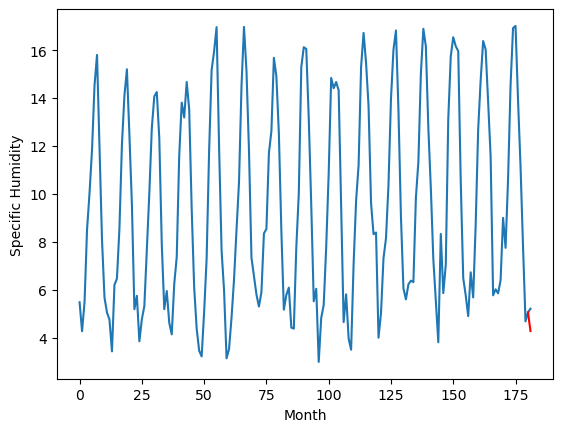

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.21		3.98		-0.23
[180, 181]
[7.05, 3.9769951993227]


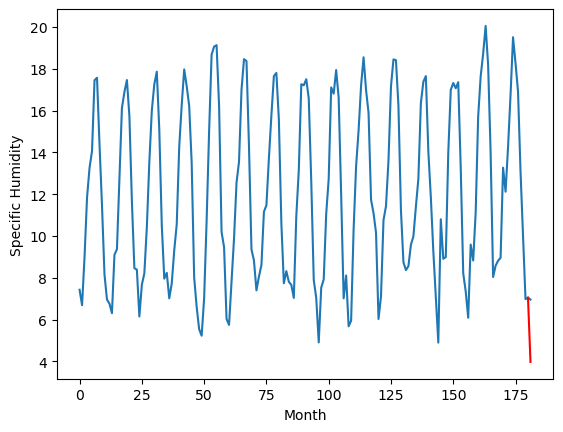

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.32		5.23		-0.09
[180, 181]
[5.2, 5.2269951993227]


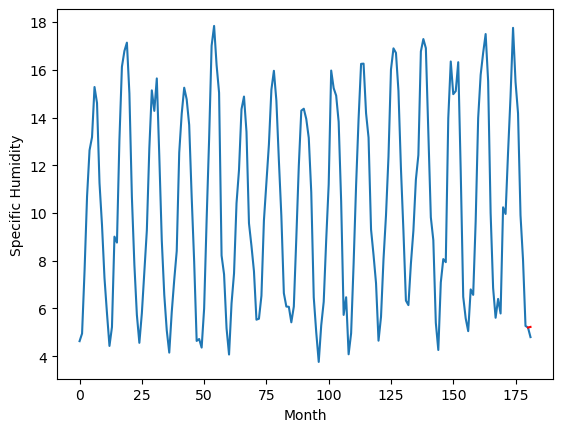

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.42		7.87		0.45
[180, 181]
[5.16, 7.8669951993227]


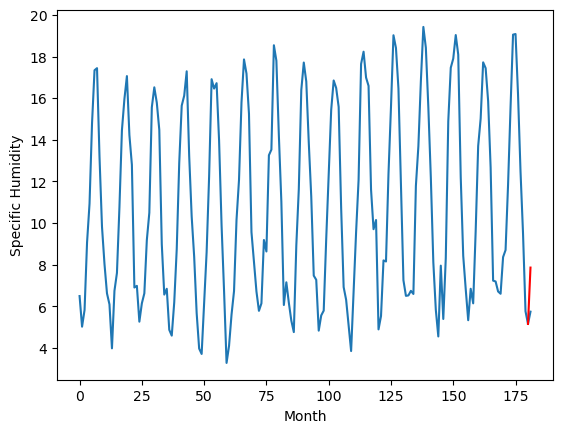

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.33		5.32		-0.01
[180, 181]
[4.05, 5.316995199322701]


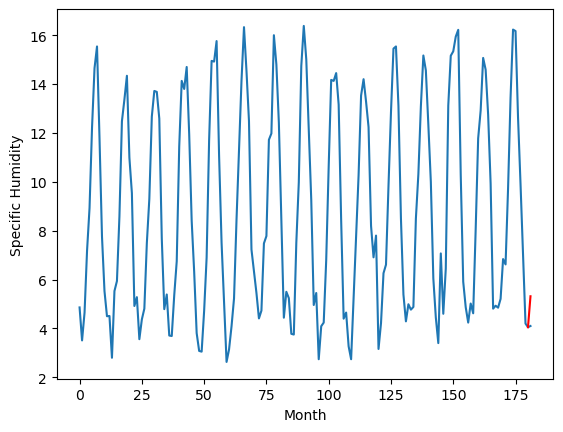

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.12		7.27		0.15
[180, 181]
[3.64, 7.2669951993227]


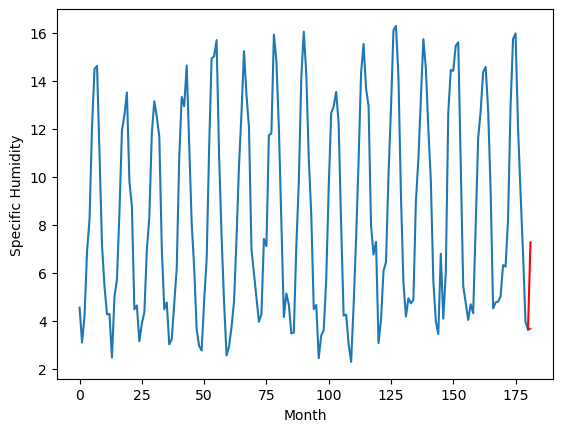

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.40		4.47		0.07
[180, 181]
[3.46, 4.4669951993227]


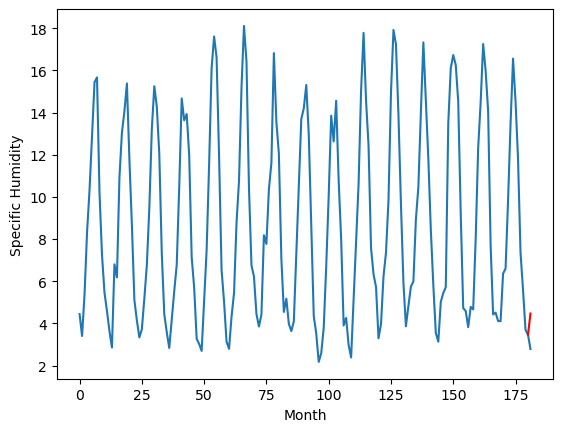

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.17		6.34		0.17
[180, 181]
[2.93, 6.3369951993227005]


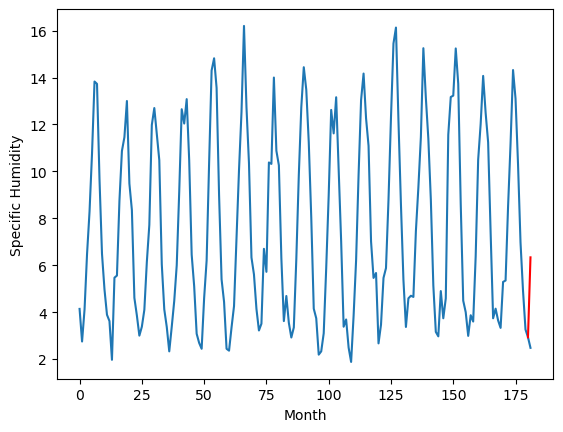

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.48		4.70		0.22
[180, 181]
[2.74, 4.696995199322701]


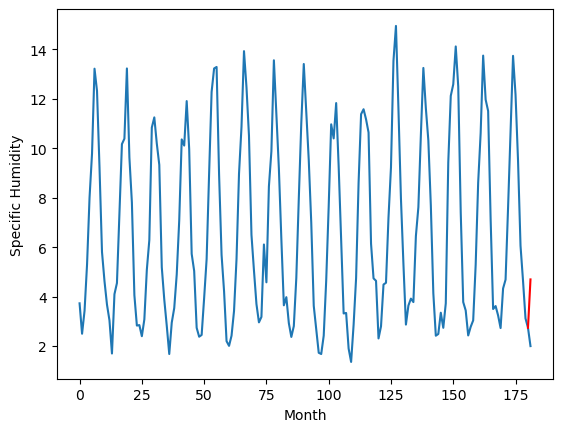

RangeIndex(start=1, stop=12, step=1)
[4.62, 4.899999999999999, 4.820000000000001, 4.209999999999998, 5.32, 7.42, 5.33, 7.119999999999999, 4.4, 6.170000000000001, 4.48]
[4.696995199322701, 4.3869951993227, 4.276995199322701, 3.9769951993227, 5.2269951993227, 7.8669951993227, 5.316995199322701, 7.2669951993227, 4.4669951993227, 6.3369951993227005, 4.696995199322701]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.62   4.696995
1                 1    4.90   4.386995
2                 2    4.82   4.276995
3                 3    4.21   3.976995
4                 4    5.32   5.226995
5                 5    7.42   7.866995
6                 6    5.33   5.316995
7                 7    7.12   7.266995
8                 8    4.40   4.466995
9                 9    6.17   6.336995
10               10    4.48   4.696995


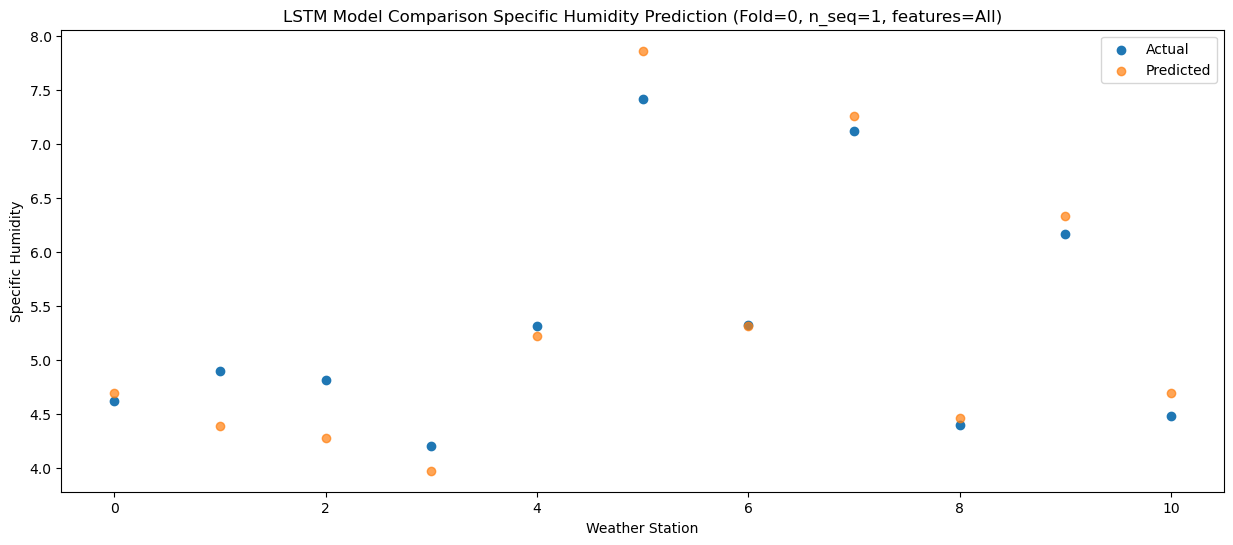

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (1, 1, 256)               2462720   
                                                                 
 dropout_10 (Dropout)        (1, 1, 256)               0         
                                                                 
 lstm_11 (LSTM)              (1, 256)                  525312    
                                                                 
 dropout_11 (Dropout)        (1, 256)                  0         
                                                                 
 dense_15 (Dense)            (1, 256)                  65792     
                                                                 
 dense_16 (Dense)            (1, 128)                  32896     
                                                                 
 dense_17 (Dense)            (1, 1)                   

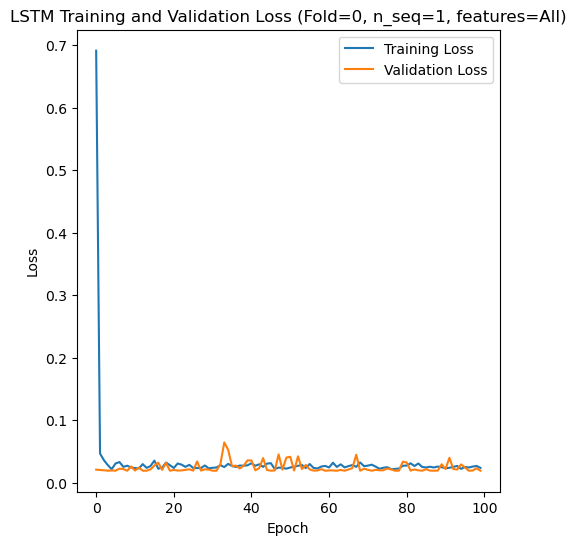

Epoch 1/100
84/84 [==============================] - 6s 26ms/step - loss: 0.6855 - accuracy: 0.0000e+00 - mae: 0.6855 - rmse: 0.6855 - mape: 138.2622 - pearson: nan - val_loss: 0.0572 - val_accuracy: 0.0000e+00 - val_mae: 0.0572 - val_rmse: 0.0572 - val_mape: 11.8743 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0258 - accuracy: 0.0000e+00 - mae: 0.0258 - rmse: 0.0258 - mape: 5.1978 - pearson: nan - val_loss: 0.0159 - val_accuracy: 0.0000e+00 - val_mae: 0.0159 - val_rmse: 0.0159 - val_mape: 3.2373 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0406 - accuracy: 0.0000e+00 - mae: 0.0406 - rmse: 0.0406 - mape: 8.2034 - pearson: nan - val_loss: 0.0146 - val_accuracy: 0.0000e+00 - val_mae: 0.0146 - val_rmse: 0.0146 - val_mape: 3.0150 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0264 - accuracy: 0.0000e+00 - mae: 0.0264 - rmse: 0.0264 - mape: 5.39

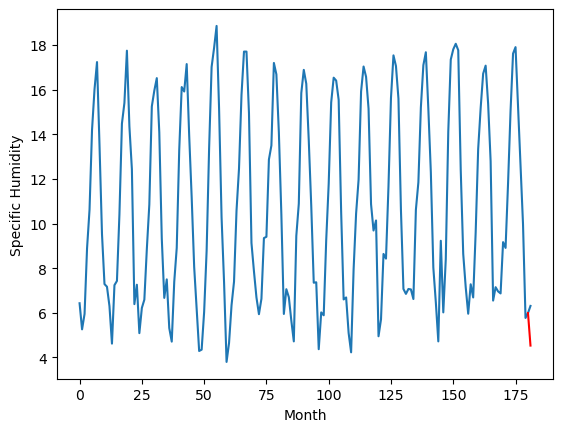

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.34		4.04		-0.30
[180, 181]
[4.15, 4.042267538309098]


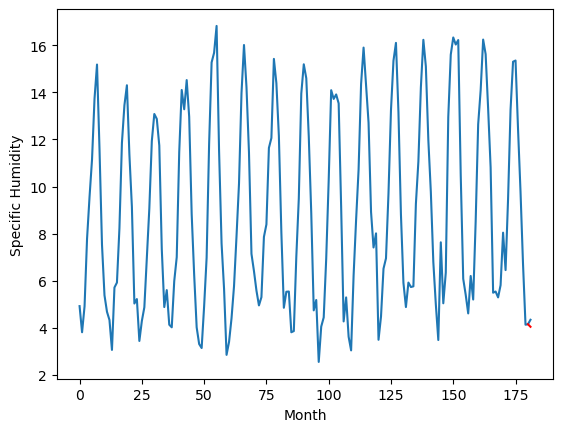

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.22		2.79		-0.43
[180, 181]
[5.12, 2.792267538309097]


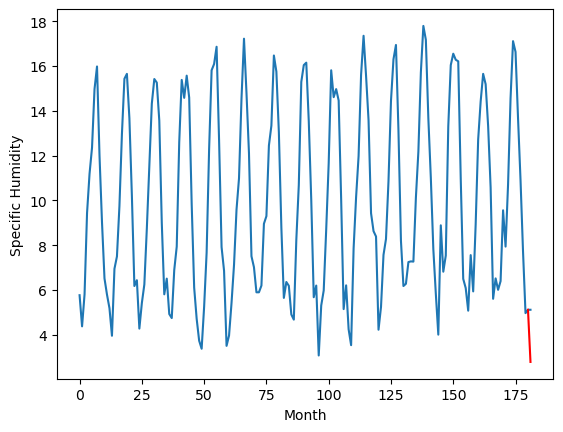

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.03		2.09		0.06
[180, 181]
[6.35, 2.0922675383090974]


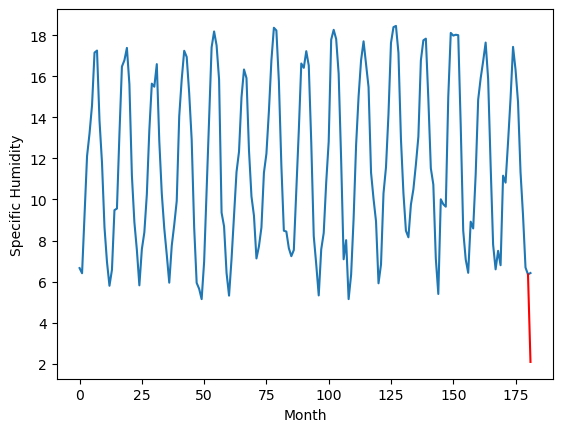

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.18		6.15		-0.03
[180, 181]
[6.08, 6.152267538309097]


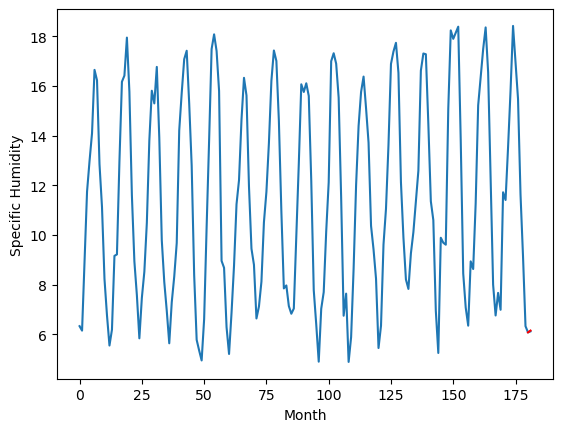

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.75		4.64		-1.11
[180, 181]
[3.92, 4.642267538309097]


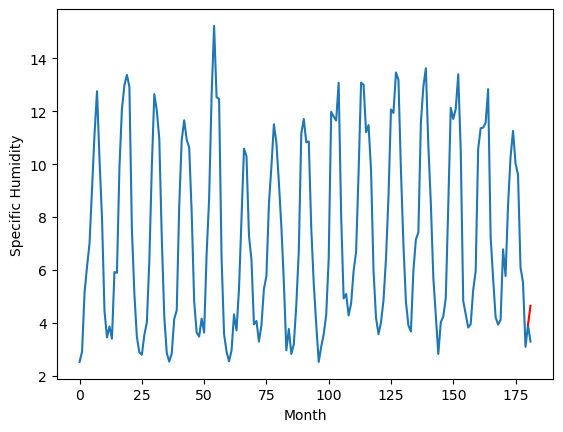

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.66		5.49		-0.17
[180, 181]
[4.16, 5.492267538309097]


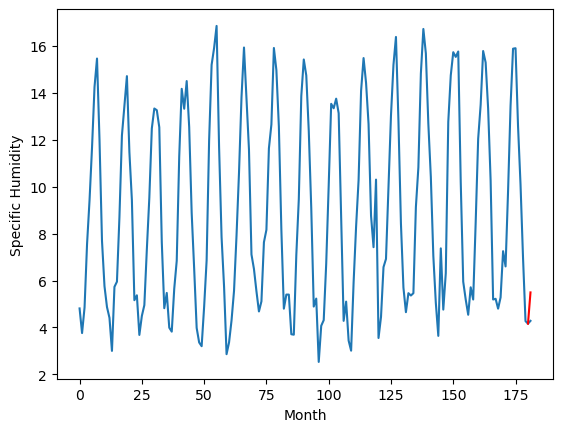

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.53		6.38		-0.15
[180, 181]
[3.84, 6.382267538309097]


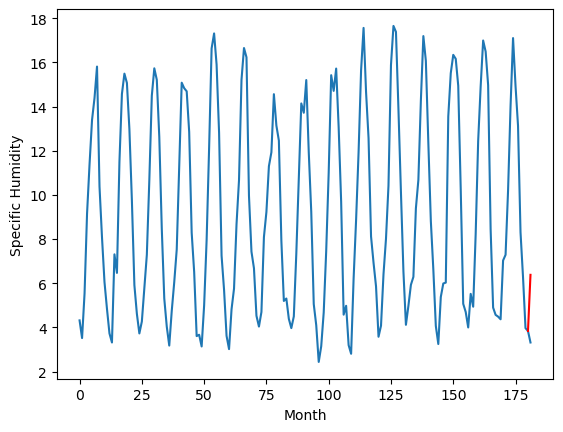

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.49		6.05		-0.44
[180, 181]
[3.73, 6.052267538309097]


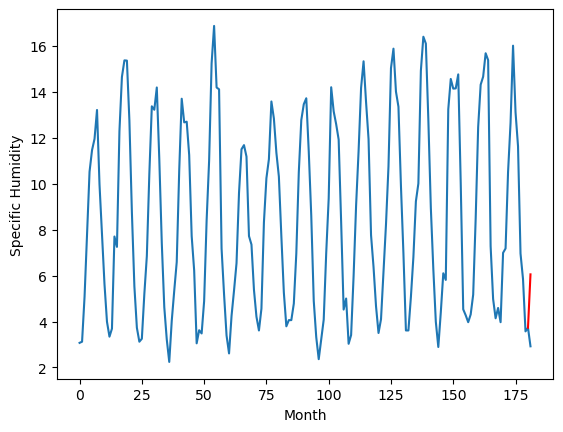

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.71		2.24		-0.47
[180, 181]
[2.83, 2.2422675383090973]


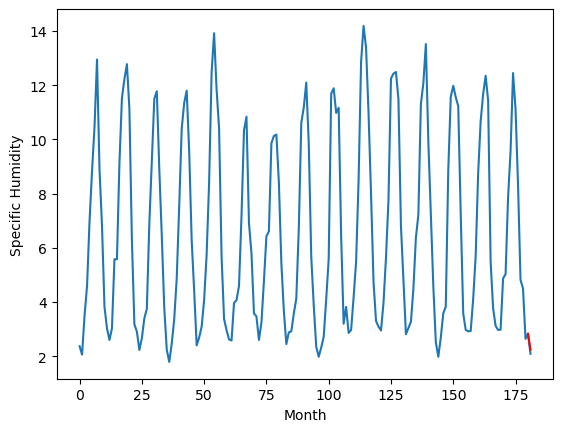

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.08		4.53		0.45
[180, 181]
[2.69, 4.532267538309097]


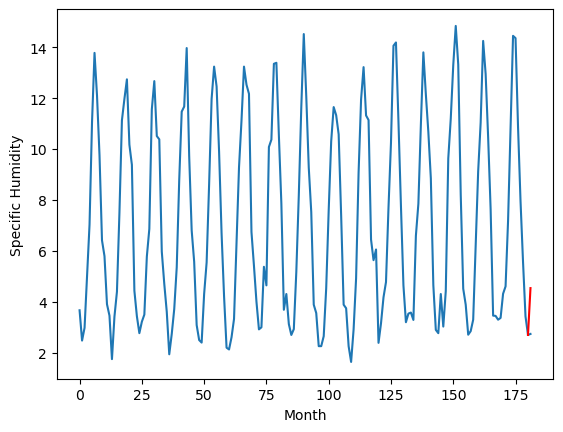

RangeIndex(start=1, stop=12, step=1)
[5.03, 4.340000000000002, 3.2199999999999998, 2.0299999999999994, 6.18, 5.75, 5.66, 6.529999999999999, 6.49, 2.7100000000000004, 4.079999999999999]
[4.532267538309097, 4.042267538309098, 2.792267538309097, 2.0922675383090974, 6.152267538309097, 4.642267538309097, 5.492267538309097, 6.382267538309097, 6.052267538309097, 2.2422675383090973, 4.532267538309097]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    5.03   4.532268
1                 1    4.34   4.042268
2                 2    3.22   2.792268
3                 3    2.03   2.092268
4                 4    6.18   6.152268
5                 5    5.75   4.642268
6                 6    5.66   5.492268
7                 7    6.53   6.382268
8                 8    6.49   6.052268
9                 9    2.71   2.242268
10               10    4.08   4.532268


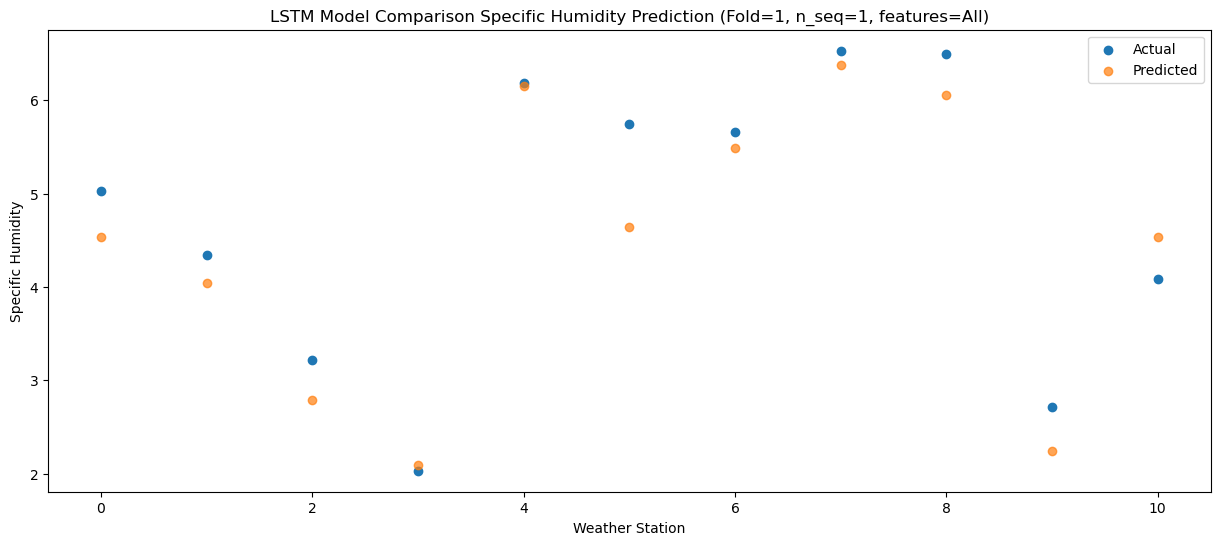

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (1, 1, 256)               2462720   
                                                                 
 dropout_12 (Dropout)        (1, 1, 256)               0         
                                                                 
 lstm_13 (LSTM)              (1, 256)                  525312    
                                                                 
 dropout_13 (Dropout)        (1, 256)                  0         
                                                                 
 dense_18 (Dense)            (1, 256)                  65792     
                                                                 
 dense_19 (Dense)            (1, 128)                  32896     
                                                                 
 dense_20 (Dense)            (1, 1)                   

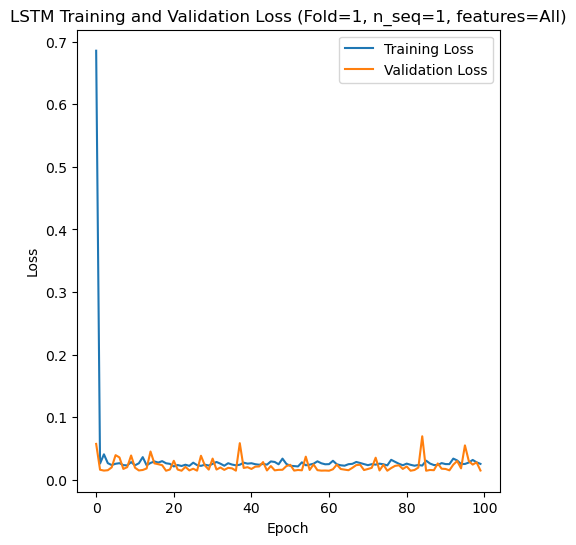

Epoch 1/100
84/84 [==============================] - 6s 25ms/step - loss: 0.5971 - accuracy: 0.0000e+00 - mae: 0.5971 - rmse: 0.5971 - mape: 120.6602 - pearson: nan - val_loss: 0.1259 - val_accuracy: 0.0000e+00 - val_mae: 0.1259 - val_rmse: 0.1259 - val_mape: 26.1635 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0320 - accuracy: 0.0000e+00 - mae: 0.0320 - rmse: 0.0320 - mape: 6.3713 - pearson: nan - val_loss: 0.0189 - val_accuracy: 0.0000e+00 - val_mae: 0.0189 - val_rmse: 0.0189 - val_mape: 4.0696 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0243 - accuracy: 0.0000e+00 - mae: 0.0243 - rmse: 0.0243 - mape: 4.9123 - pearson: nan - val_loss: 0.0225 - val_accuracy: 0.0000e+00 - val_mae: 0.0225 - val_rmse: 0.0225 - val_mape: 4.8429 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0217 - accuracy: 0.0000e+00 - mae: 0.0217 - rmse: 0.0217 - mape: 4.35

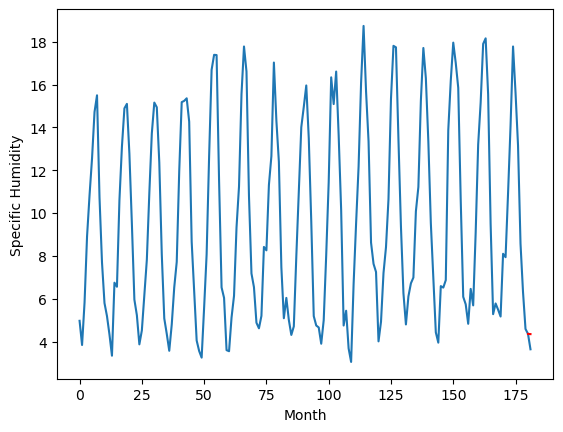

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.84		1.62		-0.22
[180, 181]
[2.82, 1.6186079823970794]


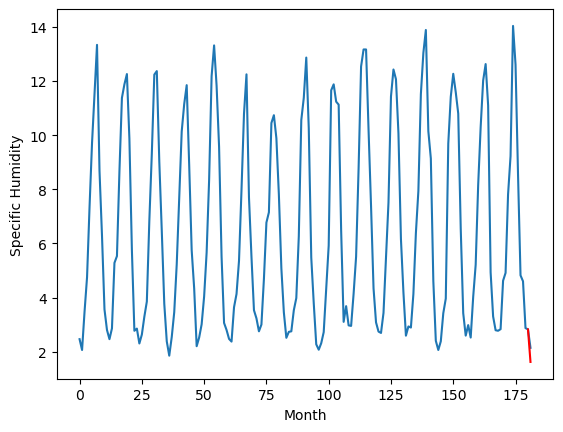

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.53		4.77		-0.76
[180, 181]
[9.16, 4.7686079823970795]


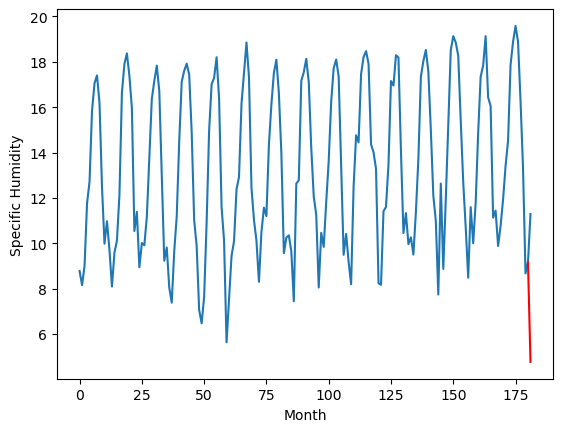

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.98		4.79		0.81
[180, 181]
[2.44, 4.788607982397079]


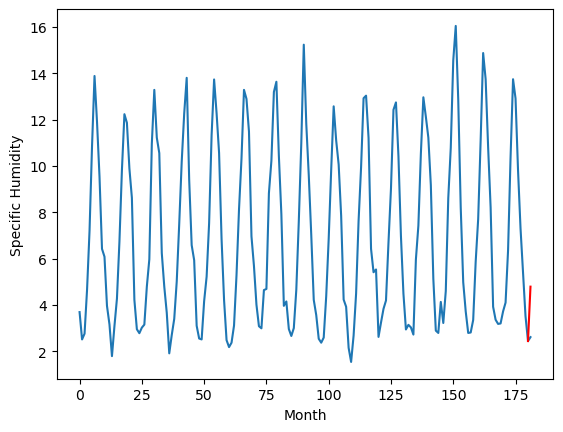

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.10		4.70		-0.40
[180, 181]
[6.65, 4.698607982397079]


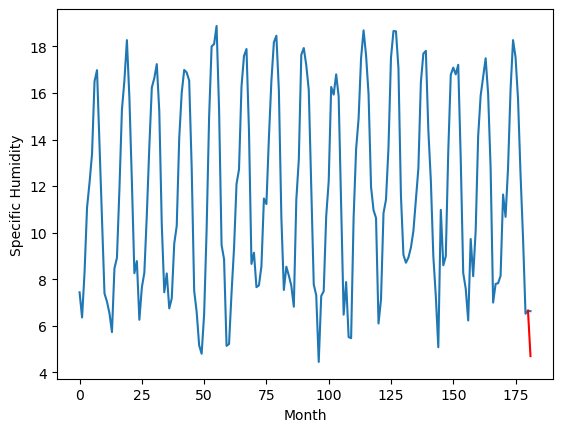

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.33		2.19		-0.14
[180, 181]
[6.19, 2.1886079823970794]


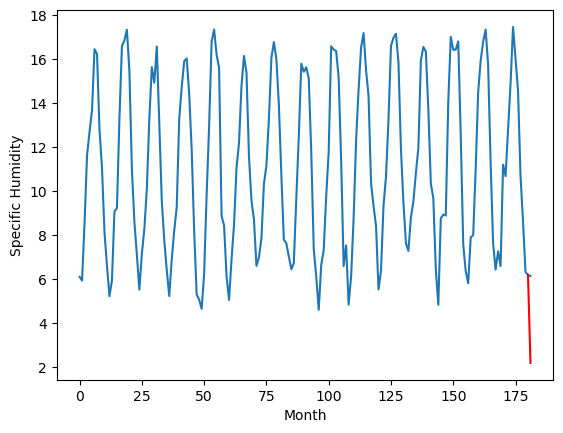

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.68		8.51		-0.17
[180, 181]
[4.78, 8.508607982397079]


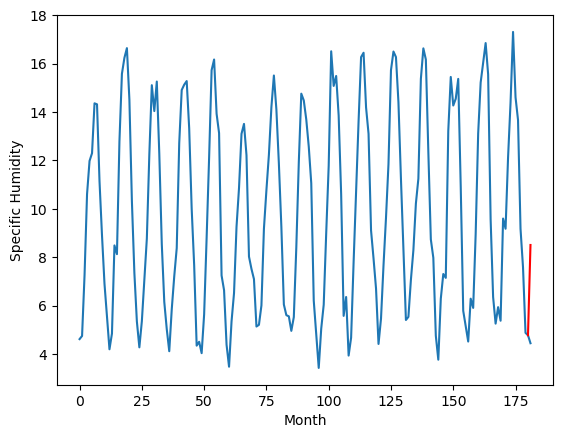

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.97		3.42		-0.55
[180, 181]
[2.61, 3.4186079823970794]


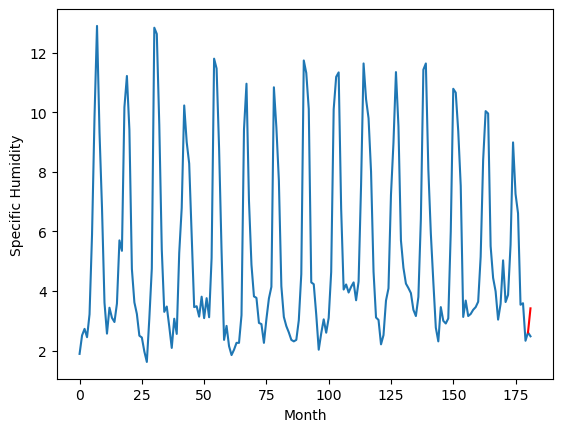

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.29		7.17		-1.12
[180, 181]
[4.6, 7.16860798239708]


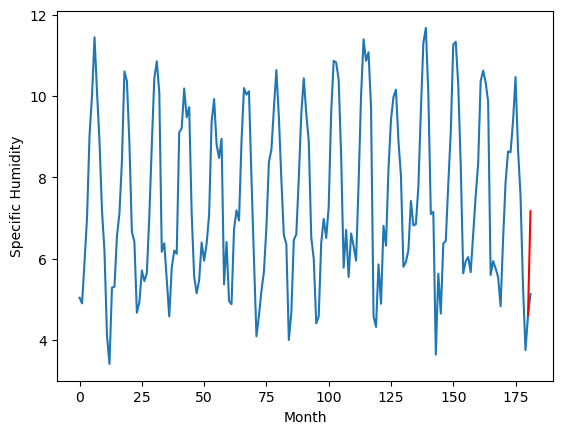

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.98		5.83		-0.15
[180, 181]
[4.27, 5.828607982397079]


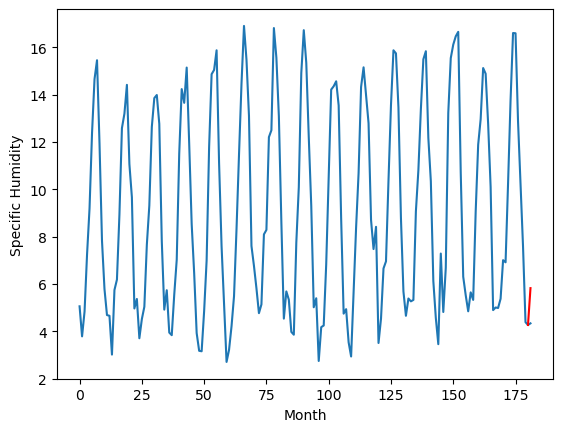

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.63		4.35		-0.28
[180, 181]
[3.91, 4.34860798239708]


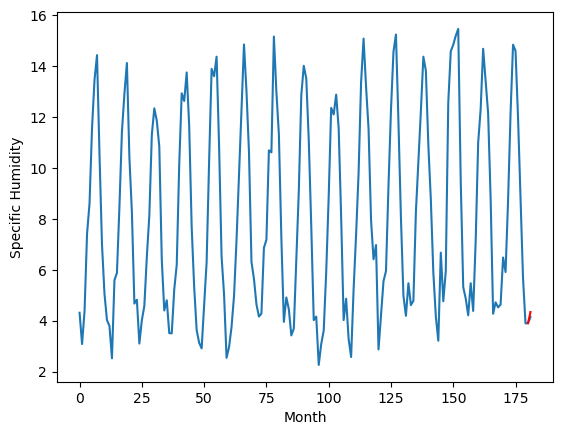

RangeIndex(start=1, stop=12, step=1)
[4.390000000000001, 1.8399999999999992, 5.529999999999999, 3.9799999999999995, 5.1, 2.33, 8.68, 3.9700000000000006, 8.29, 5.9799999999999995, 4.63]
[4.34860798239708, 1.6186079823970794, 4.7686079823970795, 4.788607982397079, 4.698607982397079, 2.1886079823970794, 8.508607982397079, 3.4186079823970794, 7.16860798239708, 5.828607982397079, 4.34860798239708]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.39   4.348608
1                 1    1.84   1.618608
2                 2    5.53   4.768608
3                 3    3.98   4.788608
4                 4    5.10   4.698608
5                 5    2.33   2.188608
6                 6    8.68   8.508608
7                 7    3.97   3.418608
8                 8    8.29   7.168608
9                 9    5.98   5.828608
10               10    4.63   4.348608


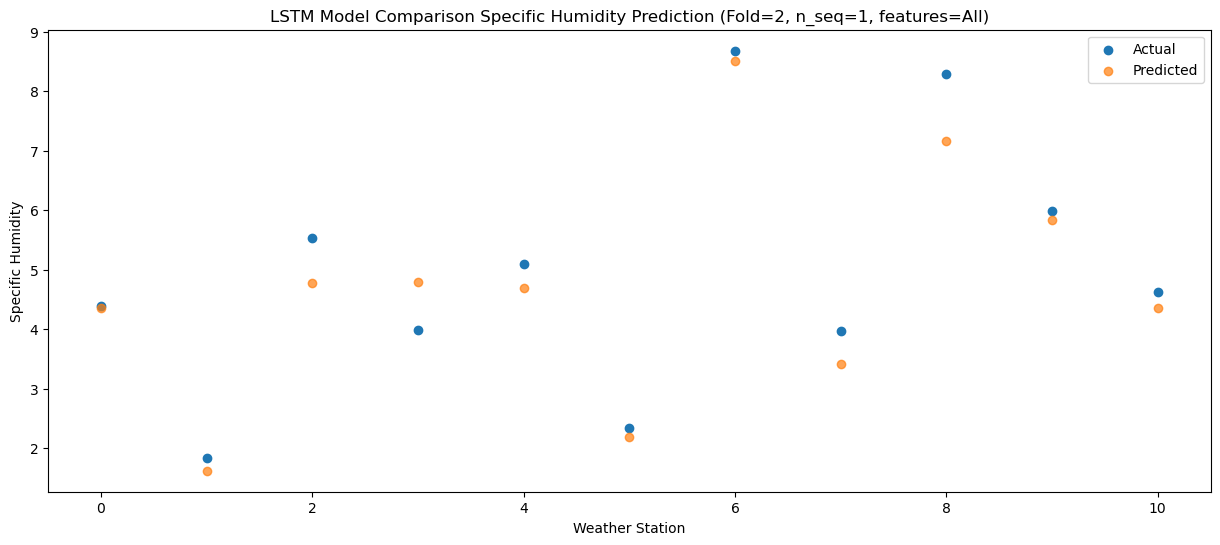

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (1, 1, 256)               2462720   
                                                                 
 dropout_14 (Dropout)        (1, 1, 256)               0         
                                                                 
 lstm_15 (LSTM)              (1, 256)                  525312    
                                                                 
 dropout_15 (Dropout)        (1, 256)                  0         
                                                                 
 dense_21 (Dense)            (1, 256)                  65792     
                                                                 
 dense_22 (Dense)            (1, 128)                  32896     
                                                                 
 dense_23 (Dense)            (1, 1)                   

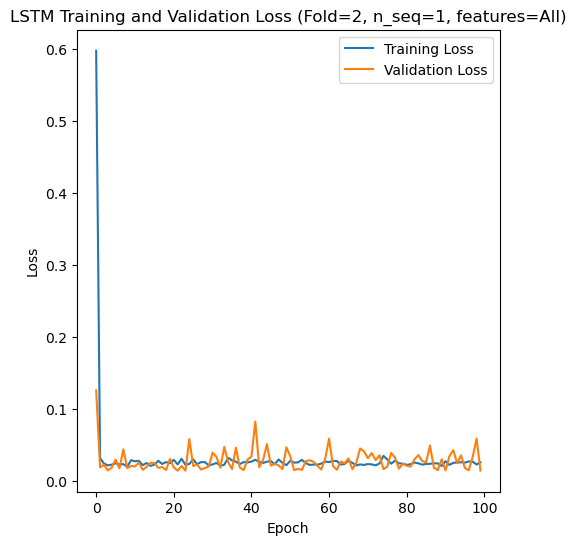

Epoch 1/100
84/84 [==============================] - 6s 26ms/step - loss: 0.7429 - accuracy: 0.0000e+00 - mae: 0.7429 - rmse: 0.7429 - mape: 148.3902 - pearson: nan - val_loss: 0.0288 - val_accuracy: 0.0000e+00 - val_mae: 0.0288 - val_rmse: 0.0288 - val_mape: 5.5223 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0282 - accuracy: 0.0000e+00 - mae: 0.0282 - rmse: 0.0282 - mape: 5.7025 - pearson: nan - val_loss: 0.0252 - val_accuracy: 0.0000e+00 - val_mae: 0.0252 - val_rmse: 0.0252 - val_mape: 4.8167 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0278 - accuracy: 0.0000e+00 - mae: 0.0278 - rmse: 0.0278 - mape: 5.6041 - pearson: nan - val_loss: 0.0190 - val_accuracy: 0.0000e+00 - val_mae: 0.0190 - val_rmse: 0.0190 - val_mape: 3.7296 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0235 - accuracy: 0.0000e+00 - mae: 0.0235 - rmse: 0.0235 - mape: 4.778

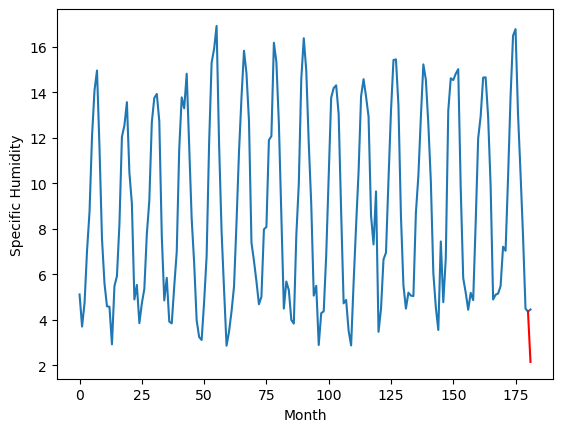

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.64		3.19		0.55
[180, 181]
[3.43, 3.1866237330436706]


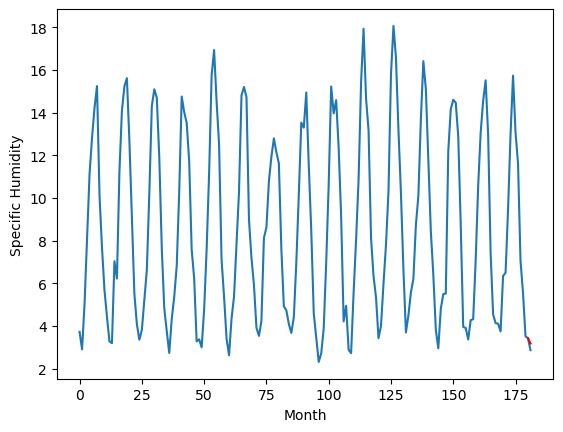

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.37		6.39		0.02
[180, 181]
[5.43, 6.38662373304367]


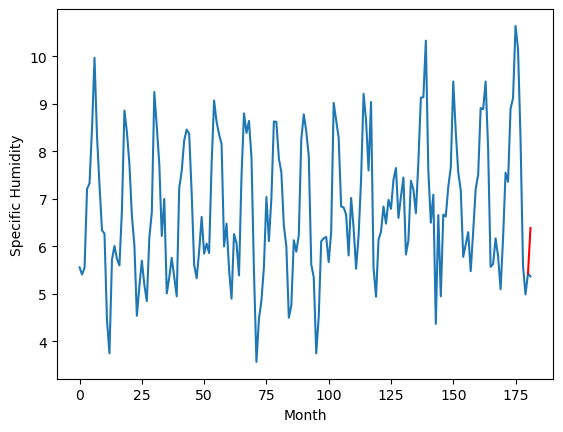

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.44		4.17		0.73
[180, 181]
[3.21, 4.166623733043671]


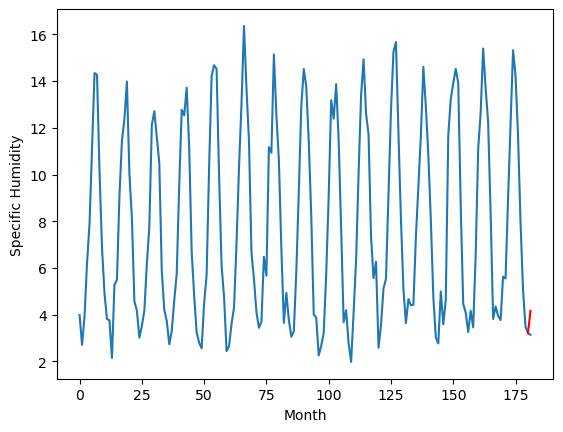

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.91		5.57		0.66
[180, 181]
[3.04, 5.566623733043671]


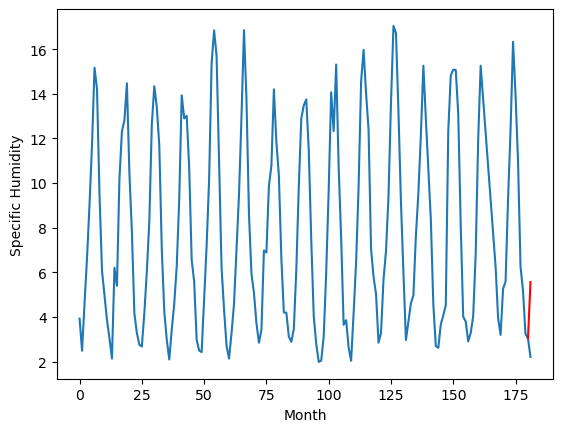

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.42		4.19		0.77
[180, 181]
[2.91, 4.186623733043671]


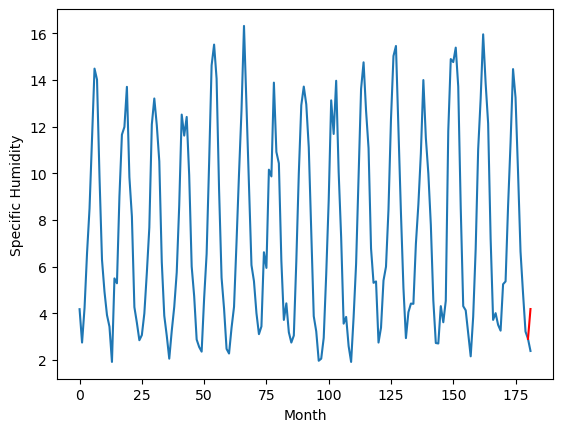

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.73		6.02		0.29
[180, 181]
[1.6, 6.01662373304367]


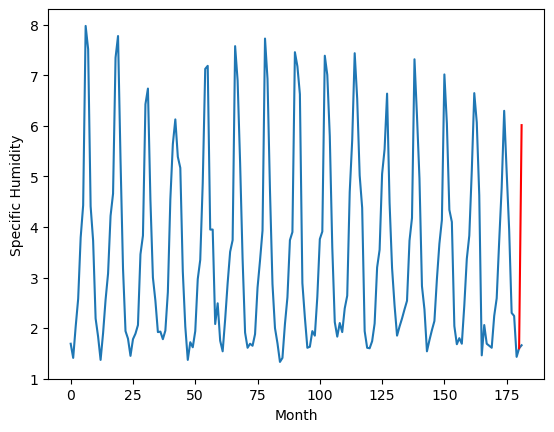

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.80		4.45		-0.35
[180, 181]
[2.86, 4.446623733043671]


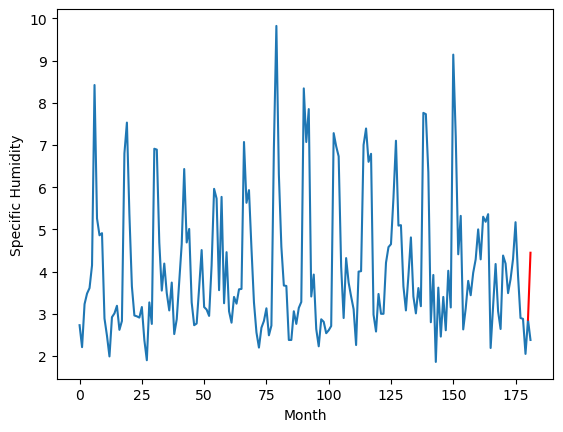

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.60		4.39		-0.21
[180, 181]
[5.65, 4.38662373304367]


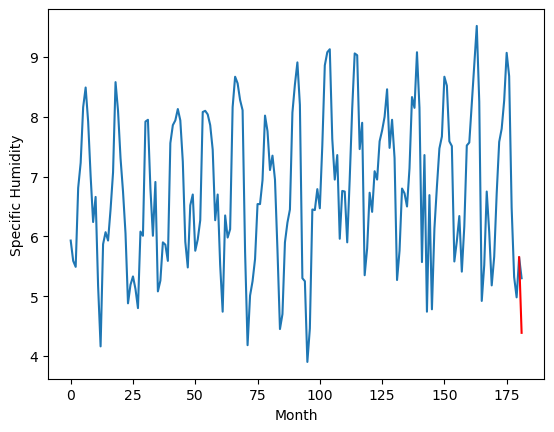

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.09		4.64		1.55
[180, 181]
[2.54, 4.63662373304367]


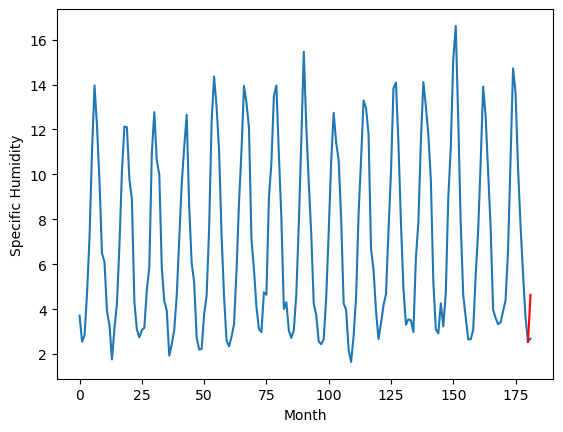

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.00		2.15		1.15
[180, 181]
[2.51, 2.1466237330436706]


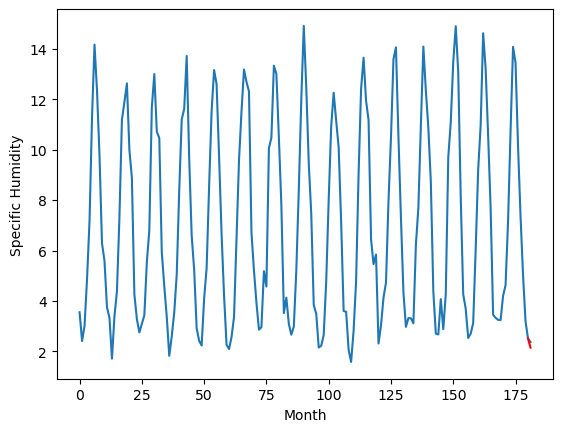

RangeIndex(start=1, stop=12, step=1)
[1.5600000000000005, 2.64, 6.369999999999998, 3.4399999999999995, 4.91, 3.42, 5.73, 4.800000000000001, 4.6, 3.09, 0.9999999999999993]
[2.1466237330436706, 3.1866237330436706, 6.38662373304367, 4.166623733043671, 5.566623733043671, 4.186623733043671, 6.01662373304367, 4.446623733043671, 4.38662373304367, 4.63662373304367, 2.1466237330436706]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    1.56   2.146624
1                 1    2.64   3.186624
2                 2    6.37   6.386624
3                 3    3.44   4.166624
4                 4    4.91   5.566624
5                 5    3.42   4.186624
6                 6    5.73   6.016624
7                 7    4.80   4.446624
8                 8    4.60   4.386624
9                 9    3.09   4.636624
10               10    1.00   2.146624


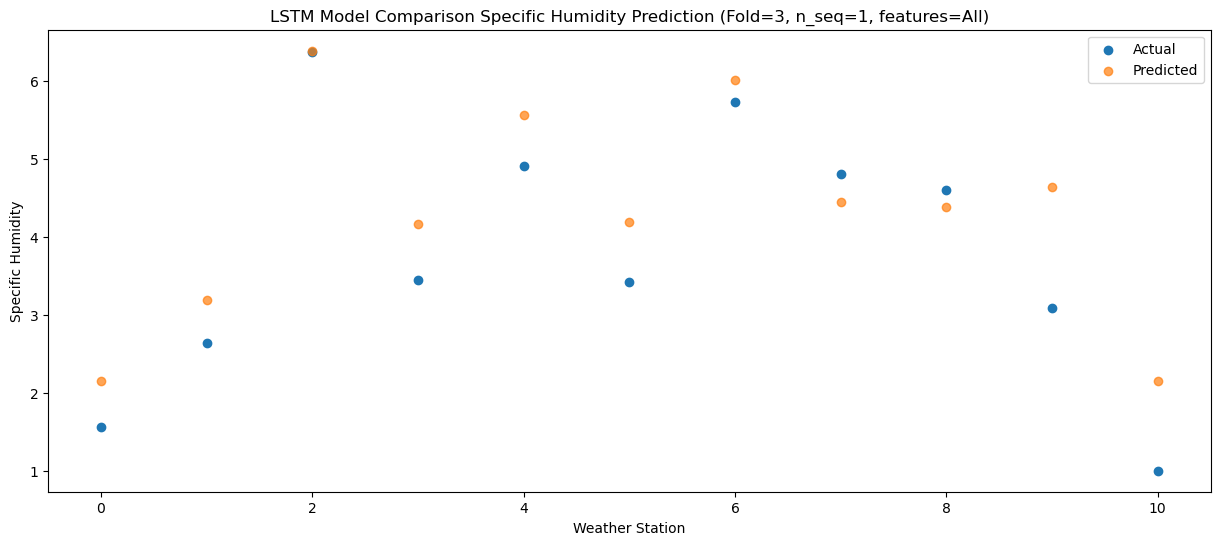

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (1, 1, 256)               2462720   
                                                                 
 dropout_16 (Dropout)        (1, 1, 256)               0         
                                                                 
 lstm_17 (LSTM)              (1, 256)                  525312    
                                                                 
 dropout_17 (Dropout)        (1, 256)                  0         
                                                                 
 dense_24 (Dense)            (1, 256)                  65792     
                                                                 
 dense_25 (Dense)            (1, 128)                  32896     
                                                                 
 dense_26 (Dense)            (1, 1)                   

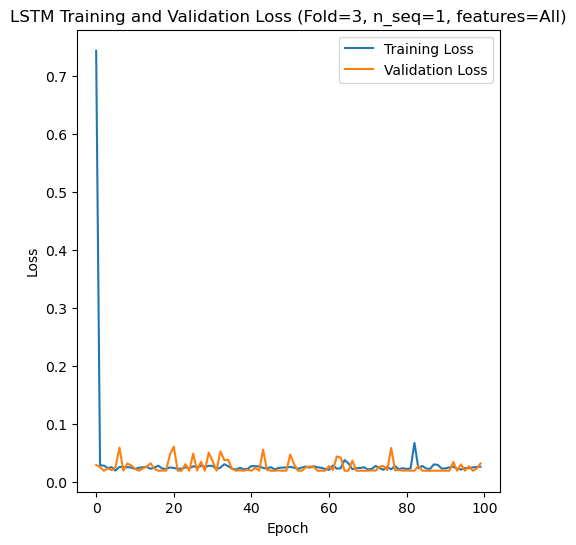

Epoch 1/100
84/84 [==============================] - 6s 26ms/step - loss: 0.6329 - accuracy: 0.0000e+00 - mae: 0.6329 - rmse: 0.6329 - mape: 133.2780 - pearson: nan - val_loss: 0.0364 - val_accuracy: 0.0000e+00 - val_mae: 0.0364 - val_rmse: 0.0364 - val_mape: 7.5658 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0331 - accuracy: 0.0000e+00 - mae: 0.0331 - rmse: 0.0331 - mape: 6.6636 - pearson: nan - val_loss: 0.0413 - val_accuracy: 0.0000e+00 - val_mae: 0.0413 - val_rmse: 0.0413 - val_mape: 8.0940 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0277 - accuracy: 0.0000e+00 - mae: 0.0277 - rmse: 0.0277 - mape: 5.6296 - pearson: nan - val_loss: 0.0237 - val_accuracy: 0.0000e+00 - val_mae: 0.0237 - val_rmse: 0.0237 - val_mape: 4.8893 - val_pearson: nan
Epoch 4/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0265 - accuracy: 0.0000e+00 - mae: 0.0265 - rmse: 0.0265 - mape: 5.366

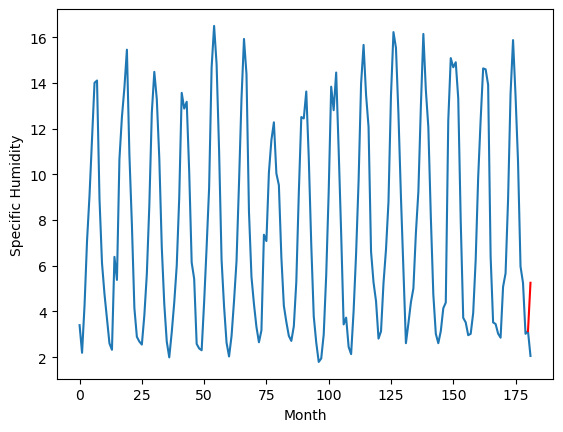

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.27		3.96		-0.31
[180, 181]
[7.79, 3.9552426767349242]


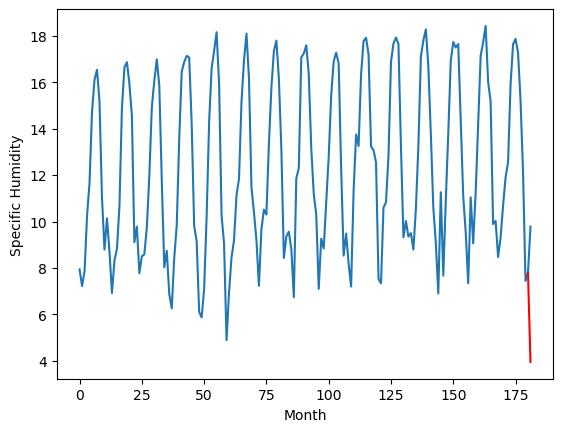

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.87		4.02		0.15
[180, 181]
[5.03, 4.015242676734925]


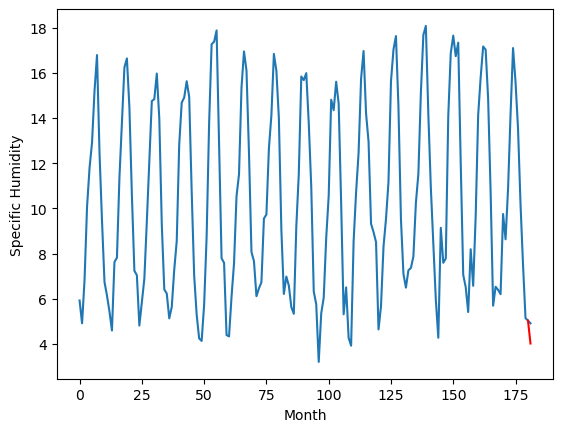

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.73		3.88		0.15
[180, 181]
[4.41, 3.875242676734924]


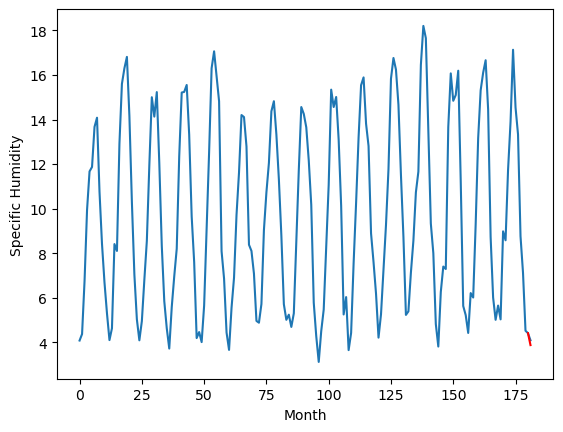

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.36		3.44		0.08
[180, 181]
[4.29, 3.4352426767349242]


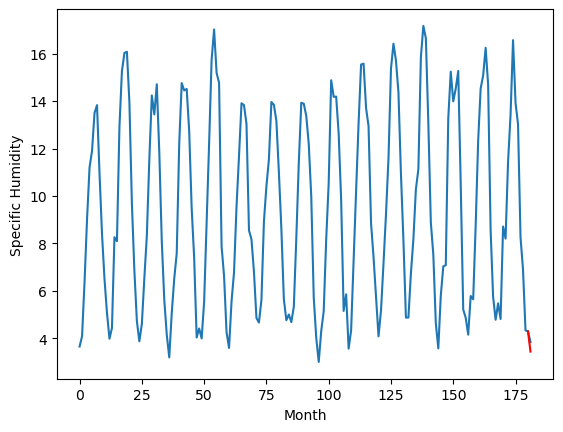

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.64		7.98		-0.66
[180, 181]
[3.47, 7.975242676734925]


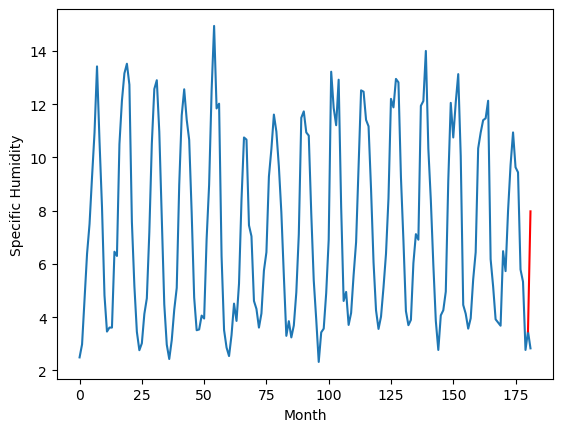

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.80		5.96		0.16
[180, 181]
[4.52, 5.955242676734924]


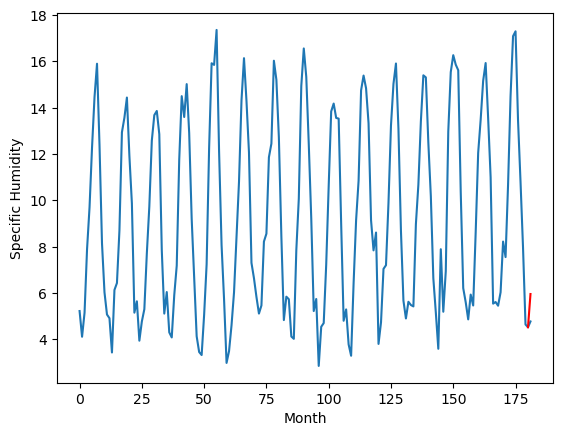

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.93		4.12		0.19
[180, 181]
[3.4, 4.115242676734924]


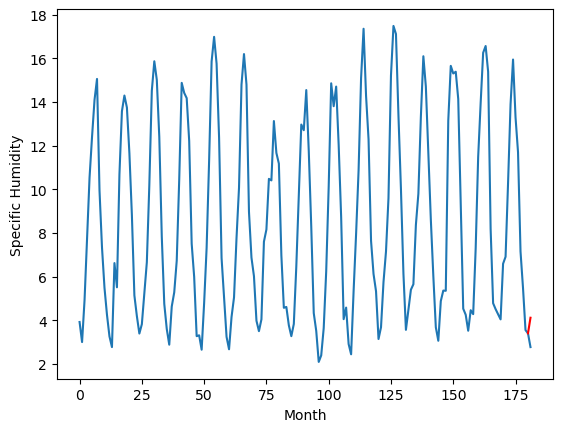

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.30		3.69		0.39
[180, 181]
[2.82, 3.6852426767349242]


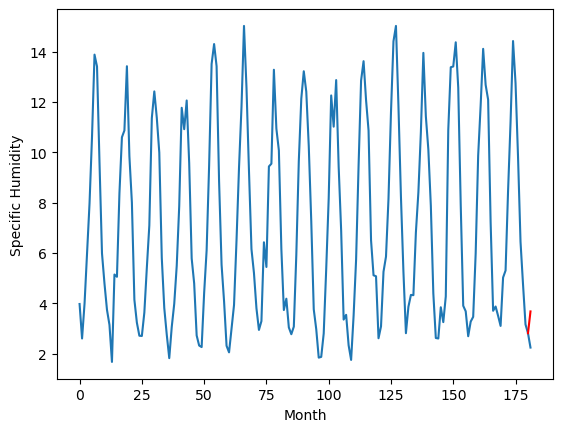

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.17		2.53		0.36
[180, 181]
[2.86, 2.5252426767349245]


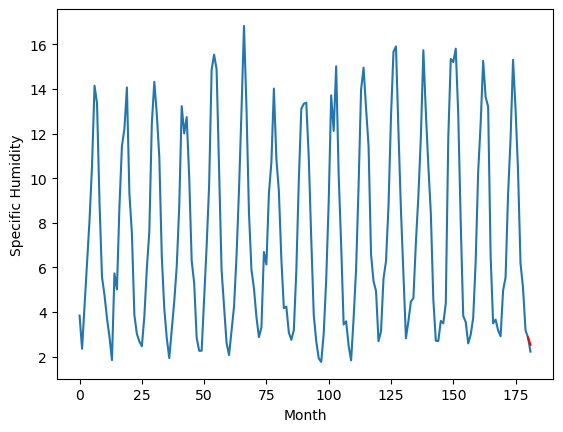

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.84		5.26		0.42
[180, 181]
[2.61, 5.255242676734924]


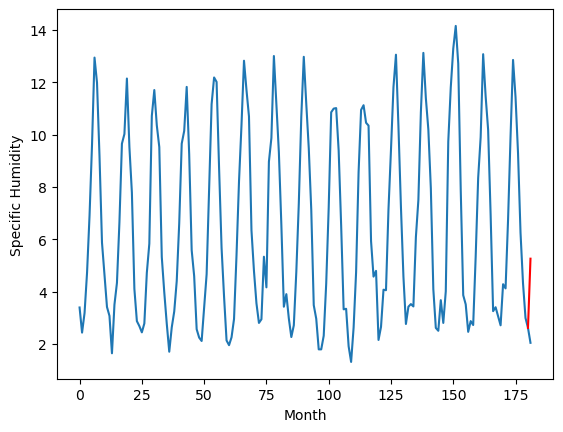

RangeIndex(start=1, stop=12, step=1)
[5.34, 4.269999999999999, 3.870000000000001, 3.7300000000000004, 3.3600000000000003, 8.64, 5.8, 3.93, 3.3000000000000003, 2.1699999999999995, 4.839999999999999]
[5.255242676734924, 3.9552426767349242, 4.015242676734925, 3.875242676734924, 3.4352426767349242, 7.975242676734925, 5.955242676734924, 4.115242676734924, 3.6852426767349242, 2.5252426767349245, 5.255242676734924]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    5.34   5.255243
1                 1    4.27   3.955243
2                 2    3.87   4.015243
3                 3    3.73   3.875243
4                 4    3.36   3.435243
5                 5    8.64   7.975243
6                 6    5.80   5.955243
7                 7    3.93   4.115243
8                 8    3.30   3.685243
9                 9    2.17   2.525243
10               10    4.84   5.255243


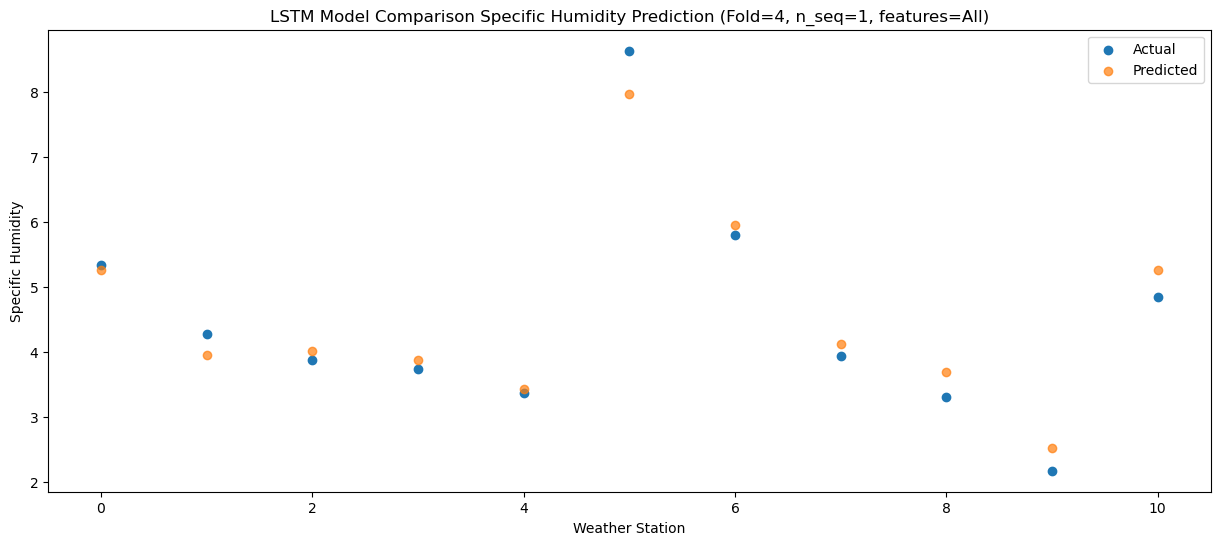

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (1, 1, 256)               2462720   
                                                                 
 dropout_18 (Dropout)        (1, 1, 256)               0         
                                                                 
 lstm_19 (LSTM)              (1, 256)                  525312    
                                                                 
 dropout_19 (Dropout)        (1, 256)                  0         
                                                                 
 dense_27 (Dense)            (1, 256)                  65792     
                                                                 
 dense_28 (Dense)            (1, 128)                  32896     
                                                                 
 dense_29 (Dense)            (1, 1)                   

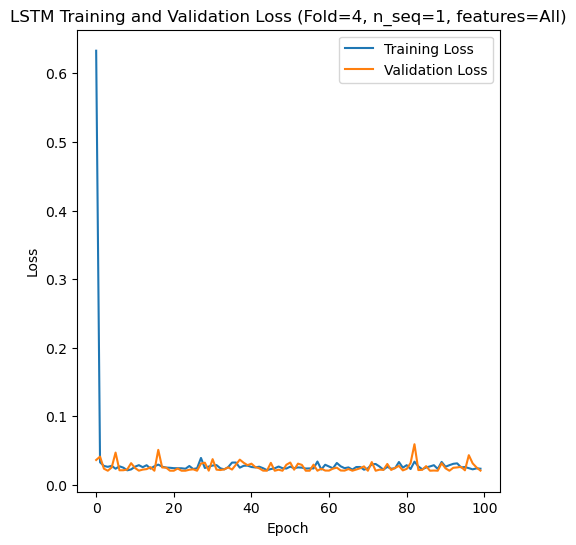

[[0.2904450537025917], [0.4686482662722261], [0.5358450506328309], [0.7476872414298263], [0.3164377726879049]]
[[0.2288177453929725], [0.372193384712393], [0.4229571053114803], [0.6223969210277905], [0.2660193985158746]]
[[0.043718207970385704], [0.08466832830777676], [0.08999888536096196], [0.27018188494525885], [0.0641391279542026]]
[[0.9230975246539136], [0.9020318297317846], [0.9303320576325506], [0.7817656946284584], [0.9622544371877255]]
[[[4.696995199322701], [4.3869951993227], [4.276995199322701], [3.9769951993227], [5.2269951993227], [7.8669951993227], [5.316995199322701], [7.2669951993227], [4.4669951993227], [6.3369951993227005], [4.696995199322701]], [[4.532267538309097], [4.042267538309098], [2.792267538309097], [2.0922675383090974], [6.152267538309097], [4.642267538309097], [5.492267538309097], [6.382267538309097], [6.052267538309097], [2.2422675383090973], [4.532267538309097]], [[4.34860798239708], [1.6186079823970794], [4.7686079823970795], [4.788607982397079], [4.69860

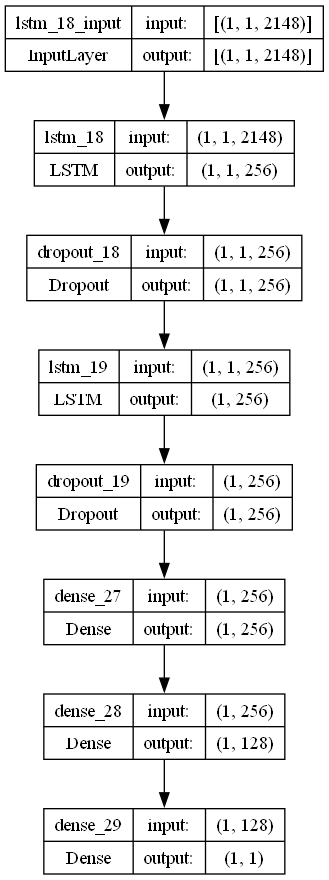

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from best model
    lr = 0.031100585463278898
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.26665809118262074

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with an LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # Create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S1.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)